# Reverse time migration example on a 2D  acoustic model

In [23]:
# Add module path
import sys
import os

currloc = os.getcwd()

sys.path.append(currloc+'/../../devito/')
sys.path.append(currloc+'/../../examples/')
sys.path.append(currloc+'/../acoustic/')

In [24]:
from examples.containers import IShot, IGrid
import numpy as np
from examples.acoustic.Acoustic_codegen import Acoustic_cg
from devito import clear_cache

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import ndimage

# Dimensions on constant initailization

In [25]:
# Define geometry
dimensions = (201, 201, 70)
origin = (0., 0.)
spacing = (15., 15.)
spc_order = 4

# Load velocity model

In [26]:
# Read velocity
vp = 1e-3*np.fromfile(currloc+'/../data/marmousi3D/MarmousiVP.raw', dtype='float32', sep="")
print(np.shape(vp))
vp = vp.reshape(dimensions)
print(np.shape(vp))
vp = vp[101, :, :]
print(np.shape(vp))
dimensions = (201, 70)
truc = (vp <= (np.min(vp)+.01))
# Smooth velocity
smooth_vp = ndimage.gaussian_filter(vp, sigma=(2,2), order=0)

smooth_vp = np.max(vp)/np.max(smooth_vp)* smooth_vp
smooth_vp[truc] = vp[truc]
# Create models
model = IGrid()
model0 = IGrid()

model.create_model(origin, spacing, vp)
model0.create_model(origin, spacing, smooth_vp)

(2828070,)
(201, 201, 70)
(201, 70)


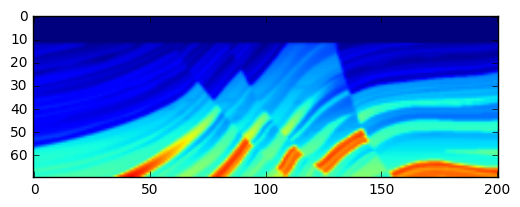

In [27]:
# True velocity
fig1 = plt.figure()
l = plt.imshow(np.transpose(vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

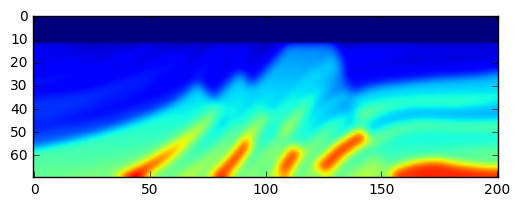

In [28]:
# Smooth velocity
fig2 = plt.figure()
l = plt.imshow(np.transpose(smooth_vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

# Acquisition geometry

In [29]:
# Source function
# Set up the source as Ricker wavelet for f0
def source(t, f0):
    r = (np.pi * f0 * (t - 1./f0))

    return (1-2.*r**2)*np.exp(-r**2)
# Define seismic data.
data = IShot()

f0 = .015
dt = model.get_critical_dt()
t0 = 0.0
tn = 1500
nt = int(1+(tn-t0)/dt)

time_series = source(np.linspace(t0, tn, nt), f0)
location = (origin[0] + dimensions[0] * spacing[0] * 0.5,
            origin[1] + 2 * spacing[1])
data.set_source(time_series, dt, location)

receiver_coords = np.zeros((101, 2))
receiver_coords[:, 0] = np.linspace(2 * spacing[0],
                                    origin[0] + (dimensions[0] - 2) * spacing[0],
                                    num=101)
receiver_coords[:, 1] = origin[1] + 2 * spacing[1]
data.set_receiver_pos(receiver_coords)
data.set_shape(nt, 101)

# Shot record

In [39]:
Acoustic = Acoustic_cg(model, data, t_order=2, s_order=10)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/75b3f9b44d6549ae5f7c039be900c58c6b7bd814.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0d3556792239451b81cbb222659e3ea853fe0cb5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4b358702bd1a5c7ffc743cf43b030acb617bd4a2.cpp


In [40]:
print("Applying Forward")
rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac300365b6a4ea89d8336d9f6b60baa272ac7286.cpp


Applying Forward


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/68323d7ab1031a3f461fe4901dd68dd8d64aee7c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5d7a357e6e2250effc3a0e3ebacb0fe71ece2ec2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/87d465d5186129fa2cd7f62f969fa61cff52fc5f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0dc9073e733bdfa9ec8da0386db3f09f1a2e8bed.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.786746 s (19 MCells/s)


Stencil: 3.437500 OI, 1.16 GFlops/s (time: 1.784014 s)


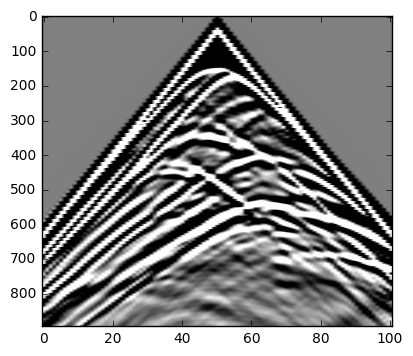

In [41]:
# Shot record
fig3 = plt.figure()
l = plt.imshow(rec, vmin=-.1, vmax=.1, aspect=.1, cmap=cm.gray)
plt.show()

# RTM

In [42]:
nsrc = 101
sources = np.linspace(2 * spacing[0], origin[0] + (dimensions[0] - 2) * spacing[0],num=nsrc)
grad = np.zeros(dimensions)
grad = np.pad(grad, [(40, 40),(40,40)],'edge')

for i in range(0,nsrc):
    print("Starting source : " + str(i+1) + "over " + str(nsrc))
    location = (sources[i] ,origin[1] + 2 * spacing[1])
    data.set_source(time_series, dt, location)
    # True data
    Acoustic = Acoustic_cg(model, data, t_order=2, s_order=4)
    rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)
    # Smooth data and wavefield
    Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)
    # gradient
    grad =  grad + Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f804b7fa3458f463af127526957c5b285a8442a9.cpp


Starting source : 1over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/57c552e2b779a0054832c4d1648d92316699da46.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/41e6c8cf7ce443645affebf8cf461767db41b0a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b89438d3dae0608fef5fedf9a949cb44c3f28e3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/53abdafe48c1392920c87f6c31499265b3351494.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/151fd059a8945d209e6fb722579457cb24459223.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/573c7484636023af7cb92d9b6ecc6c1dca40f7cc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5a807bb425b1854984e2ef2c4488406d1dc50361.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.020213 s (35 MCells/s)


Stencil: 1.937500 OI, 1.15 GFlops/s (time: 1.016642 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d3af01c6632a960a8278cb1cbf00ba1ea586b3bb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d0fa811f1616aa823b03d1e2eeb986c41102072b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/59d82f43b807c3bede22b57546dc2fe2b429825e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ce4d9dcbf1a51112830b6f112ab8632ba683f8d6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e221aad6f20459d41c91f383a6e20093d859e906.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1c90643f3434101833d86e827bd6605ea3fe5b44.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8500b00d7746f5bda05a32e500f1995d174ce1a6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/185845cebd694cba18f9d949b4ad9d226be20833.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.902337 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.900468 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e5a0aa61c91198e938930abfbef220ef1041edf7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/40267516f05023ade695a1d1aac5362b3b63a04f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/97b2e96bc3016b553d227029c98053e2e2335608.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5da6a5710e4cc1a76140aecc0edd8d0d001c09e6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3c702bafd99f7f36795b5a9c090a3bca475532f3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8ab875fa10c530ea315700a059220730fc25d7ba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f177b4499e02ca5eedab76713df913f306672ced.cpp


Starting source : 2over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3e940ed66d720bf46dbf8da85b73b3dd106b2b03.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e61a8c0633fdc8845dc6ec50189ab821fdf525d7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4445afd288039f09978e2510b589902432199a53.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e69c900ec980c65447f18f312d280287a245f330.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3c91d0c2d2a27280527b2435b5c95ff1a64bc130.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e714c4714bbf872729af03b7b7b6f36e87752710.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/458a0faad9f5b69b5ae2af59194e24235f288c32.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.120622 s (32 MCells/s)


Stencil: 1.937500 OI, 1.05 GFlops/s (time: 1.116654 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c309eab1c5c9f7871e81943eeabf9b252803757a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/578a5adb57690d3ccc901219edeb6e1443fcc230.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d4739c2c2ecc7ff478713e05a090666d3020d845.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f79018ef6dfb18fc57066a03ac0edab3eb87ac44.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e5c48de5dab0cf0411cc177b0075fe1c593d97a6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4b5191a0361b5c398a278aac5825dcd39b821f4e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ceda392c83f7e6b27edc7b944bf732c34ccdd519.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f26d47abbdabf5fd4fdf68ebc0e7ede13614f32f.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.052220 s (34 MCells/s)


Stencil: 1.937500 OI, 1.11 GFlops/s (time: 1.049382 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f0ae508874159fb12621ef589170df8601d270ea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac7052b9e9842255fc54412b9d281c90d1eff7df.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/974fc1e6c7ffe1f982b23a3d8f612b9cbed531a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e678d878c541970e4f6563df3af764b83a640feb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eeda9a853b8018acc31e14552a2fe5605e6ea9cb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0ca4bf7c8b98a4810ee2e033f1de2b0cdf200d82.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b9f546c2bd99c2d535967a0c184d4beadebf700f.cpp


Starting source : 3over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/903f230f22e952c938586eccac1674432f60f9dd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1681ce273d3c3e222f0cd6882ff51a1ca5376cfa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d3599e4c64e1ea7117d196f1da71e687485ed4b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/232a35d4082d8ad20cfc997cd578450892bd8c97.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2cba3e3d5dfc580f5f719c49410db49a440854a0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/72d95ea86553b3b48dc190b70dcf1384a04486e6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/69c11455ce2801ca06017629773af868ccd7c18f.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.878589 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.876616 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/afa8de8ea3f2d734bc384d7fec8f1589047c8b8b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c762dfcb731e5dc30adbb45b9970a5375e73f927.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a45a6ba19b67413e5823f28fae461c72e1801805.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aeb16e1ca49e1d235a04e2f0c6cfb35ed1f59e96.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/523e446b7e17c44a4cc70ec6acf989131a02c1a6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/43324b87fa959843a4cecf5131c9f81fa6582f76.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/35a309896b5d5582ff8fa127b090337236410359.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c30a3ec4f03cc23aab21c6a444eda161d2d4c1eb.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.935859 s (38 MCells/s)


Stencil: 1.937500 OI, 1.25 GFlops/s (time: 0.933802 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f4e75723fd25230ea9b5c6198b349de8426c67fc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a766c9fc24816051c8073a889db64c75461ba987.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7b0e10892ae525fb8b9ba3d3cb954bb6e52f8064.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/81df59ba4d1038a7da96a06d8e8c6b33b45cf8f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/08e78eb299bcab6c951f362bc0de41f8c4a206b1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a1217c993033690b40de7e16a0b524a49a71f28a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/792fd592b732c2e28a9e613bb267ed3e208e6cd4.cpp


Starting source : 4over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/87d513fec73e2ee4cebb6b6a7c6aea6bedbd2326.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2848de6b5411fa8de6ca09ade77001aeb5b03a45.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d5131e7f36cbf1b8da782f293f7ee18635eff7d6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3d173daefdbcb8c99a7ac5df5b4b859aa5a524c4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c3f461931ae80185804937af1986aa790be094ff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6f105dea6b56b07b04260cd49289c7b8b6edb60c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5b4a4d4f8f8add8546a27c0fff67a2507f982e24.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.861234 s (42 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.859477 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f4507bd2188887de5e73c37c2e496c4d0f10919b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f77d81cd16792b24daacdf8ce55197bbe797401.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8bd9399d009564304ca840eede3825cf5152add4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/37caf5da9c19a7e2a0da2f7148c9000efd126783.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4207a4fd1e0e1f5f75e186fcc482ee9d90ebb15f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/07204f7aa98236215248757c5d4c577fcf30828e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c0d3da5f879c5423708577d008722f945df33b9f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7fa7942c97cd68b14ad3f9929e23c601e3c2b824.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.893727 s (40 MCells/s)


Stencil: 1.937500 OI, 1.31 GFlops/s (time: 0.891785 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5e2caf42c3df0da32f7c62ce5b8ddba6b22593ce.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1e01436159a1746bb3f86f061e137ced9530916a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3b7fb19f5f1e7d6252a7bb35fe436d5f43eb7483.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bf363c1d7d843fffb326474d89c9633cfdf6cd12.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6c5e70b48773a5ee822c80db2337dbbc28bd7aee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/89e97b472f6e37069f7a8ca757263843af0f671d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/353c99d5afd66229911a4741395c73d7377e1175.cpp


Starting source : 5over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ab0311874e786f21035109bc5b4934fc69bfd6b4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/790f2b2176a5ace9cbfa22874275a7f725665e28.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4f2e192c8bc81875986a4e4651bacf2fe77a8d59.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/46931f1ae3ccdcf6c0c130ab27f5ba90b95ac214.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/19db22b3bb618f4a8556b438f125a56cb5bd621b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/17fc9643f2e98105e9b187ed054d22e338b79a7c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/501108814ae7643e672649af20af2e5824992eb6.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.846986 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.845313 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/72514358c9bb694f862d8fcd1a4f5fdc95751431.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5d6f60d4226790d1189ebfb6ed664a7a3811c5cc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/69b28c3c7fedebf67987d0f964909d5763dbf8ec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2be5b72bd87cfc16815eef8c14ee483e879e37d0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/645836da5fdbe8df0858e99c4e1e9fde0423945f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/833265b9aee14baef87b8389f153386b5f998815.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ee16670e48d0d45242d6c47cee4630e6227c4b15.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/869b0b65bcc971546e3a7c08f57ebf68e32667d0.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.879993 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.878194 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b5dfb2f90058d98bb7caa5894b55615f4d6cab30.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d5cc4fe9ef457eec5d51ecb2e9fd0489c42263d4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/efd58396e44ef3f8062236234c1ac20f995b6861.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/02280f22c205bad34822cc569af9373735be3c1e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e6abb05ecfedcd8196aa7dfa60216897b28a8925.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eef02a488bcba7c5dadc679b0ba3f271471437a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe8bcd805896a1137e901fbc1428710b240a45ff.cpp


Starting source : 6over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ffc391e0ed5482a1687ff329e84f778b8d3b2a3e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/26e3a0bd2f9a3f44f644ec8f869b6b99107ffa14.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/953b9145b830233ff93630bc9edbfcb3364ee351.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8e3eda4102bc56d41daafc38c347e398a3b4b356.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f7b32567059db74df5ef70ba2c2378909ec5d046.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/31371cd8bb3947ba3f79174c4af895242848cfdd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/87a63a4d20feaa9bbb820265592d85e23df03765.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.903294 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.901155 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe71fcee1bbcf2d15127ac052cf6330d95f92bed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/db7ba02051384d3936485348c4631f2d94a49aa7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/99a6fff0f37c05cd960df3cf1d73498208de4fea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c47523ba1cffe982e0f087a8b23f546ea598fdfc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b4e3e8ca3400e39fc43649e4b375e6cd5e1dd32e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/43f6b9e33fa53c2d38145bd50620d2103efef845.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bd2934d8a52ad303ddb4c846a19b5a4912833833.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4a8255b10a47b08f1771ce957b8df36e24a55e8f.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.947522 s (38 MCells/s)


Stencil: 1.937500 OI, 1.24 GFlops/s (time: 0.945319 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/52dce67c549bf0e2c9459229dcb0db797417c507.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d1e59d8e84b167c839d9f1a10259e849404de008.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cc4734a7e52bbb9ed6a61ec703bc70bfb1233822.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6708f485129f6c55ff9ca98f77757e422027ce0a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/560dc705c91547dd5c0a13f90bb64ae5db79f774.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/07662ca6f5c77a7c112f4727c439b4f64eaa214d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c9b75faaa1d4c3317aecca1703ad2632590f18ae.cpp


Starting source : 7over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0419e1c5492844b17463d5d838db18ccc373da1b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d3c7fb4ad50981b2c7be0b025ffc38589c1969dd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9baf3100a1165773c67f00706545a1116c6de567.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/35ca77272e0b2a69c8b51b23a44fb6b99bb7b7ab.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aff2d46ccc7afba673f606cdb098ddd0739a1603.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6982ba00836f574c36aed1264e8ae33b56b40520.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f179d95d7d659ff71cbe34685d6f629c7865a36.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.914826 s (39 MCells/s)


Stencil: 1.937500 OI, 1.28 GFlops/s (time: 0.912340 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dc2abce3cd60818dbbffe9991e9e3b6e350189a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/230315e781e548f917227377cd5d80156316935a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/abf029194fd4e40aaa7d45bcc0297b8ec8dd9787.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3b88791c89fa2d6850a760d59e5a4b639ffc2986.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d6a9e2f80a86c54e7d4fc29a8afc217e55816c93.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ef46692cddfd480808b33e3b080f2323db35194e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c6bb01c3a7ded67008b464efe064ec9c54e69f54.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cf989aa400fb275ea2d2496c089ff60443976101.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.883313 s (40 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.881499 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/633eb4771d5550dd5a2613fd4d814e74202563c5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7b726c06d48c3a82a0c35fab07207cfa13e60443.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a61fcad9e84fe19e81fb818da6d2aa76f647c8d1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fbfdf734b0b69b85342c0828c21fdefeae5a2bcd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b4f5d83bfba704432f8c19c06e7ba83fdb6676a1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/571b863f0ee9334a415f1acbac2e33a4e4dd0afc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9380e3adb4c28e93e3eb9a7e681d0e60edeaa7e8.cpp


Starting source : 8over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/882b4912eb8d5e3285f30346bda3d96987f8c07e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/772b48592c3e33e801260cea1635b15df98bb41c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/21e96603deaaef1b1fe775fd56dfcebeb565700b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/28d86845f29fc7ead5b6127e2290b0103dd0b08e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/20a132b3c1cff556924b2694c9aa3d52055b6ad1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ad5fd02a3631dc6a7fa7343158c1ed860d00ceec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/591a1a47e98bf7a2dddd139f93fd9aca7413ee83.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.867980 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.866069 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/31f797913ca56245a95d00da8768edf1ee1cc944.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2c28d42f87f4289fc384bb2da7786a4420746718.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/49bc0b91c461b0b520c84d8863cbb418063ffbee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4b30d8b2715fb161d066584a8a2373029905fe8d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e8c784de392e66654adb41886ef1734096a13de6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/13de764a5c0bfcc66bb8fa6590c753ded4fba706.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/91b1a4e36aa27e02060a1c7bfb7e2ebdf7b4c1a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/72ccd2854af9280777e440fbf3fd2d7736280173.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.882205 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.880368 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5e874cec8e81cd279fbbe8936b989e587f1a9fb0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7f91a16cad328501d06da1b9940ddc3740d043d4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/385513ca1793e4568800fa88728f83d8c33098dd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/82cf89d23407131c61c141d9fa6d65b602535329.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c98d6321ce931fffc6cb4b3c190ba9915443d187.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e4c6cc8696cdc78c0da16962a48e9e25bf8b0af2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/216f6768d057b0ec56458fad677d9eecb925d206.cpp


Starting source : 9over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8dc4090ea0efd64aec69ae00a91c7772b1fca680.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/834335af3fd0c68080314e000d77a0d7d731cfb8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/64538891b416d8bbc832329443168bf331fc93c2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f21eaa0e0b5ca1357670648e4cf397f860cf64b5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a8baba7d50befc77107a41a84498fcc42adf85e8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/393fc378d0aafb98f65ce2ea9bf266cd4c5c85d0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9f15bfc82b2da756239088c2bcb7b429afd8da25.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.849941 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.848130 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8e542dcd59816d7110415bfd3943309eb3b0c3ad.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1a483c37d4e02943e9381714d2c46a3377d5c655.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5a9a7bc489635df15db63b15808ef68b7351f959.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bb4140a53f103af8d7749e48c324394687cd9ac9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a3de2d3ab96aecbb633fcb4071d996e5fa9c24ef.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/649279e25197160c899a088cdaa1377e79a19ca0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/15ce34b73a3058cd16cb012f47dbcdb15fcbbb4d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4a6e63f9f10876a2684024c4a790c41aae6a62da.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.880368 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.878543 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ecdca9c2ad3a380549811f64765478f945658e79.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/93a6c0c8a820559e8de2ebb5d4707b1a8b746e09.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c067e2f2d9aab9752e947a52aa71812e6436b08f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/edca3e837244873993f3910ddc5e3da7726187ec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f0a991ab9e0602e41485aab939e7733c3b95be2d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9998636285166046a338307d84213d728ac0effc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/533c21d7f7a5295687c47fabae02704097026efc.cpp


Starting source : 10over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ecec3cb0690756af13627e53c8a5f77668686926.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/52223ba71dc70bffa32c2cf8176f4fbd5c9f06b0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e51ceeb806c3df198ca6ff5626444c50310ec29c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ec3f44a521ae48c78023da30820a6694c5a4f9c4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f66b4307d716171a514c42f2ee4ae59429d67f0c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ef67242917f65b322122ad044e75baef0fa85174.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c284ff8c1adbee5ddc0bf0c98d49c97a8a60820.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.856633 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.854792 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/79de13a0d4931d7e5c0ec2d553779f136c38568c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8ab258cc1246cba626a9bc32b3d16cfc58ab3449.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/839361e196cd77215a8455b8b6e38b1ba25b2491.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ba3f3c32482e5685f3ae472fd9a088f39b622033.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aa7ac9351f404c44c3a25e96a749b1e25027e1eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/45e1259a87c3ee7e68148abaebd26353260c3d7b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/75db44679227f5b785832535b6448cd8b932e3ea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/51ceecfb74d8436900358809ca1ff9d26130d068.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.890812 s (40 MCells/s)


Stencil: 1.937500 OI, 1.32 GFlops/s (time: 0.888901 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5efe0eddf6cc63cac85087c84821728702c4419f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/229dae039aa9ba9e2950d8f733dbf8576f15d516.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/69bd2653dabcc24dd977e6c2149331abb296192a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f8d7b27240288f264011a1fcd20bcc109b5e295b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3f0726b427e620de275a826e2a2fa568246738de.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/994c4593d1857e37258febf15f2f20c60a92c6aa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2377c0cb52f7b78ebd72a96817f86c06294f3e18.cpp


Starting source : 11over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4513bce00553a0acc5a3eb389145dc8a35acc85a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e839f594e4d8602f6f58fe7640f2a9b8204388d3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3db0c1ae742267f70fc8720e1343419516d9bedb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/437481e18305cffe0b0bc802ff38c47ab1f901dc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ec881a7817a8e5153fab051f882bd0a2a9ccd62.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/03c4d39d9bf17b043b55b2d5064fb237eeec0dae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3f9731fe080f4965fa06e5e84247086692ea92e2.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.864689 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.862686 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/22c39e278e6bf86bc8c64afe3f5ef6f1cd6903cc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c76a3594fa939c372cbc0aa878de09f0305c4b12.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b9b8f0c9e348ccd0c7399100296669f2cd0aa71b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9f58df69bda20268962713c4f3b599db9860d8c9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/183bab9f5d355fb28d76efbe5ceab769d3785535.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7d61ea04c47eceb490cfc1ae68751d1959f59f67.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d42334f0ffd702c5a5dbb57d152111326fc6478c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ca898d8ac603449014e051c0d0215a62febb5fe5.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.977660 s (37 MCells/s)


Stencil: 1.937500 OI, 1.20 GFlops/s (time: 0.975153 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e03ddaa9f3b868be03d4c6311096685c99f4067d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0aafed64bed1ef823b0be49f9e1859d8585360d0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6761f7cdf5230abc6099a78388100bcc908df565.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f26d2e055cb98a24071e80985439b20241e5b26b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/993e8d014fb372ae3d0f3d540ddde2d5e1d5ce34.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ef78e1255f13b2315044c792991633f5636277f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/df8a549692c9f6d3c9c6c15a10e204d1338e4df3.cpp


Starting source : 12over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6674845fb6750cf64def8f76ffcdd8c8515789d8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/80374a5369b1c0700cc3211d4342a516ecb13552.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b428cb18e6bd58dd3635fd830ff7533cc36087c2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/38df1c7f152a8e6808dce81d81f845faf1b777f6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a1440cde167cea1f8ce2bd390b9be133663d8f5a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/730093e192c170f33f880e9ee6b686e5d1fb468c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/08063e1d2dd25ccfbe87f82117b0966889ca2046.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.900118 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.897607 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/36383f74475c38e67e164693a06870aebbc7680a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/78adf0ceac667b76b87a01135f6e9e4333d89634.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cb224956433d6ec851461eff7ca687447dc97425.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6e3e3c26b96e7ee35a1d0142903242f3961e23c5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8bcd696b5b67b3c7b304fc55c7ca69315514ca4e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3b58f5d4b2af8e852ef354b0ebe7530804cd75e2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/95898c08440295d8653e7f125e50abcce49ad2d7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/43293176a82fd667e74f08eb6be0198d3f53b535.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.916054 s (39 MCells/s)


Stencil: 1.937500 OI, 1.28 GFlops/s (time: 0.913872 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/12f1a19771b64eef4096916cb5d6e39dc442519d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2d8a9e4ea367c16c5201a9e57b0d6bcb1a3fcf2f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c8b0c38918b56d2bd62c40e98ae33d605ddd1167.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/38f76e55274e51b7d19675797471a00e9a6c42f2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ebddc51d6bd15c91c8224fac985111f3d346d21a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a9453d529e4132481930afec8b9bc35aeaa84647.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c6d7fd2c988fd80905bdbebc7c0c6462a47c562a.cpp


Starting source : 13over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/add8c8c3cb0a3d39bcdf41ace448bcbd438effff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ff9cc02be64218e1805503267b72c0f43b69c42.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cb8ed39b390a8000382c1b38e42f261ea8463c65.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2dcc8588c99b37518315d9bf910e4df1350c22b3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/567cc77c86c18899c5d950734cf52727dca9d5bd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5fd982713cb27f8713bf9479ef4cc74ee4e2a556.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/810e93deddb361f2a54f7b0d40aa5efe2f910b42.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.844466 s (42 MCells/s)


Stencil: 1.937500 OI, 1.39 GFlops/s (time: 0.842630 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b7f8c809195adc8cd3ceadeac78bb95150ffbdb4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4eca4da3cbd4ab81635c052a40ddad52dc5cbd05.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f81d561bd71069dd3ac86a8f810e7db265651241.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/95220640ac565008e5fd1cc1da29d063dee2a107.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/41385cadeec8866594107eaea6cc97adcffc5c7a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66ce43e4a2f86fc22e4a1a724c0a20eb794290d6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4dabddfb0b48ce1c5ccff0c27fa1faaae823bd0d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fac4007d30028d1dee3d6e0b9f27500c85430b15.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.921425 s (39 MCells/s)


Stencil: 1.937500 OI, 1.27 GFlops/s (time: 0.919418 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e2ed59e20971045c8b86a4f3f1e77e5a1e1c967e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c23de312c6d63a6892d53073b3034c2925a33917.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9a14319acb7938e35013a5edaf28decac4042ed4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5616c184e851e8dd51fd9c7c1f43b29761e5dfd1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6460bd7e29354ff99b7f4653edba6ebca284778d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/679b5c0c11d6028508b7ba223a1ac57dcaa7305c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fb1a6614071caeaffeef62f8e7ce1dcc718036da.cpp


Starting source : 14over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/265882dd487e9285b5be91661316fbe2487f61a6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a3be42cfb4ce00648fc0331ffdfbbd5744147c61.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/01f3984e6ac14c33f8059caef32855b2c279a590.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/944d20a29051ccca0974b17794d428157b203ca4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0361e0d28d64c9066889bcceca6495b013dec324.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c57450c53c5d7cf2664cd78e5df7962addde5247.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1ed937e9b17d3d2f74b188a8e2cf9463b5d1506b.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.896153 s (40 MCells/s)


Stencil: 1.937500 OI, 1.31 GFlops/s (time: 0.893719 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b5224f6f865b0efbf44fab5cc2208c673f97dcc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/601fcb7ce0bf743a825ebbc61c38527c8f08b0a8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/20dd00749ad452c9a901494bb0672f739c425b53.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e94d436a7066dbc32cf33c4dc398f5a51d0c0918.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b0c98b9451be3b5f603a2b0258fd0b942e0c00c0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0797ecdeebdcfd59d20da112809150b48d1a0bb0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/40ea373e9dbef2fef00c5a578109d41c2318f5ba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1170f83d4e62c230b58213ad4ad41fc7a412e331.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.918468 s (39 MCells/s)


Stencil: 1.937500 OI, 1.28 GFlops/s (time: 0.916300 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7d3ecf9905993ea470a07c124c7a3e48367e7edd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c2a558813e14bf0fc7927cfab8687dbde628f7d5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/12a3122a87a26f10595108b0b7f36d15c1c241b4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5576cb86dd9f53d0db1c571f1d1ec1cc7633ade5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/da7fe0c9df83aea0891bbcb386bcebf9d4aa7c08.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d7d29a1df5aa5a85ae41603a0f087523e9a2eae5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/444867ff7f279c66ca95775b8221e47710c62b2e.cpp


Starting source : 15over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/148914c359f54405d340726255e32a2ca5c1c7d3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ccd9f9e10503b770b003db213720de856e8da83d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/46b4e3c5dcca7dff05a69d930e03d46de7d40b19.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9c87c74aa5b63fe57d18b7a187bf3462563b52a1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/84ddd83274eb0400bdf84cffd12e37a3f0f0c1c3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ca0645199ee5a6e8c6d7317420108e1c755df58.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a5a4a532abedb2e8e0d2b75dde28170b1eeb7a31.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.974949 s (37 MCells/s)


Stencil: 1.937500 OI, 1.20 GFlops/s (time: 0.972253 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/321fd38bce71de6438e9f415db848a9b823f28eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eab836bcf0ba663d9f7a54f76158b7e9855fe063.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a125724a300e90fc9db2925417e262855e8fe44d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e96b9b9fa64e4ec0c6cd740baf74c91f2d5417bf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5e7c0f6ac78cd206621274a9d45cb16d417c1105.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b57e09abb9baf0774dc3ed1667fa702974bd5491.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c4a9bf76a7046d154b8bd81308238ff2ec8bad2b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a85d5cc597380bde2a32bc200c79ed6ef9499cf8.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.942351 s (38 MCells/s)


Stencil: 1.937500 OI, 1.24 GFlops/s (time: 0.940121 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5ec5c26658c9cbad620832ec65fa6932774c962b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ca95664b160c9e4c1398fd5c8e9eec8a54f52f9b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/44611c23012da69765e5d65171d5fc5134046149.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6d882c0708a0b4bd65ee6ce9d8a09390412efbd5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/917d198b5d9242af341d582d6f9c20808d8e3911.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bc3341fd4d04abafd9b031373e0daff7885a992.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cb780cd4c9645d5451f84da0b0603a6f1081a49f.cpp


Starting source : 16over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/871dcc40c67b6cb9cfad4448aaed64af5beba77d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c2e685e7a4326fac7719f9ccb8f29b402c1bc546.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b409be3f253ce3061caf337f89f834b8f70e4ad3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/51b2b82ccfafb554991117ec7aee4dcf767be654.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/178569abf79dbd2bfceae783bdbef279e10a2932.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac848a58a6fdf6d40c5953af621894d2006fb761.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/14b970d3e0bf47bb6ceabe09000001159792d4af.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.901816 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.899415 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d0799794a389c925ea9fa01b834d22c9f05a8a06.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/202e1887ece36fef33ac0626fb211926dde5bbee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9c62ee41f37dc0c85c603b126a611df8369883c3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/807bed72cd003e870b7654fd31ce798cc20dcc4e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7f52c228abb4549542bd1a7bc628573f9b2f62f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b1e306e8e7bb0401d36fbbe93b3adf5ddf84d4cd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1bf8eb7fc4b205fc10ffa7794578697ce4134b2b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/22bea87f799a28d658c4cf5006b72c28f954e1a7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.027605 s (35 MCells/s)


Stencil: 1.937500 OI, 1.14 GFlops/s (time: 1.025165 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b97fedcfda97c6baa2c825be6238ee4f068a706b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7464725b045ceabadbd5c689db9c11a4718aaa38.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d1146a0d55d7a596ca98930e81f728ddd05658c1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/47e179b295f02989381a235f29a360630f76a6ae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/56736226950cf3caa19000c4d79ea48f8bef9d8e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bc99a19870523a7308a909f3044834d06622e5aa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/38c14ce28080ac652ee4b85b8fb44da21ce3baf7.cpp


Starting source : 17over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/21877f08e08dabec85887a93cf437cf8d11f0f43.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/97064e8119850564384f9f47d45974912023dbbe.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ddd7fef1ca5de9e9d144c829269fc0666a60e4e3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6f712f457494fb013d31d15d2350ad70325ea9f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/75d27f1856df09c4d114a35cc4b4b4de040cfbe5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a458abb0bd012f16d8a18f84f0b4c46283d5aba9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cfbeaf64e50e5dbd9cdcaa0e8bc2a7cfa3b65527.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.926880 s (39 MCells/s)


Stencil: 1.937500 OI, 1.27 GFlops/s (time: 0.924177 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7c7b204bc6fc7966e162616df62a1b0afc085f5f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6a98f41ef8049ad366f0d4ee063b154a77b1aacd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cc4f90a33b238d49a0f701e7df5584c9450a52b1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f161cf03a9409d3cd4d684e61ffe1de9aa170ad2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8dc9856e1ade7986924712ea1bb0c44599f331e1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e81cbf0213eca376f90de8007b509fb97e99f6ec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/92007fffe1e68df42cab046bc5fed70b58f83275.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/defbecdadab4e7457f25345714a2a6dbc19c1ce6.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.966641 s (37 MCells/s)


Stencil: 1.937500 OI, 1.21 GFlops/s (time: 0.963872 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1db6aa68ddf6145e8335640cfe33b0c559ae7572.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4fdd59b1d84b85a6bb37be9e916ea0cfa9dc09b9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1fb4ce21b103548431e031b62e2ba848977be12f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0d792877bd2acdb08d62488e1d8b8a479e7fd3ba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e331dc1db0993e90fc1014f2ba0072969a40c2b4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b92ce1b651fbac73ca2f7ac3d9c44cc2ae11dcbc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7de4d1a51d32044f6924b2371d5ed108f611139d.cpp


Starting source : 18over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3c92dc106f5c699dca27e3ad57375461ccb20359.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/69fffb6230a1fbc99891e9229dcdf5f0bd7a6c85.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/03c077731839438eb61d543c7f4d7762fc66d970.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ee801cfab58f22943e8359f3829d7e03a66660f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/37b0df1e52be0b719942a2494ac04d2af7a68c32.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/06636f50b1bae469fdcff4ccac8df072b442d826.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0ce4d5f56a575c1480db6a5ed3bcc81633823bb6.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.859972 s (42 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.857858 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/da07f8bd051137c2812a8f69e0111dbe274738c3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a81602206833f8f5b63ed66e4ccde69cff0510a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4b71cd33ef4937283f4b7fe67ae4581c3e399fe2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/860550d0c725651091ea8da6e22a57c8d050b7b2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5b1d6af6d9782d9959f38d53a92f380e15bf9c25.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7b178593eeeb88648f2e99c301b4f8f1ee4c7095.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7a43d36e372704e0387cce2c60b46c3e06548964.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a221d3323f749dd08c07c8d073e061b51475b071.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.862535 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.860766 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0b8311f5fe119f00321c1801a359554b9976df34.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/972ecdb08ef0e1a1036cafcf19a8e67997e7828d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f7a6c1ed1ec7f96cf92aa7db4f0e42ca5e634ff8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f84e82b40a19833d656a1f22868d0d1d288a9ab.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7081bc389ecb1216f2b6a6bfe89ebffde0f3a354.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8042e48d34f9982c97f2bd45b03ee30d5e4dd53c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/609e55e6e4af3c23d20f624d5efa0ea46b77c3be.cpp


Starting source : 19over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/739a7c2f5025447cde3062c9b2f6baeb7b931b96.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eb035d66fcb234e94041d86835ca0936875e3db3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d328c8d3cb4c27c7d7e10a6cc95a1809e1dbecf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b759e4209e420a8225a33b309973a5a9e662304.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9ba19ebd4d884783b15078763a5b50398c92cbe4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9a47d89086e5afb6074d71262a7f2934eb37c402.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/110ad58d3c081abfadb8eb0fc841de0ccae8adf3.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.900645 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.898332 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/47e6b40c7d4b462097192761e63564d277ad0983.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f21a13e451afc8fb25cb314dd29c11dc33e3bd70.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7d263306eb463d1539abd3949e63a23c89137f31.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/97069d977b794977dd8ff500f061e5b2fe6ec638.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a6aeb15f2d49cf4e089b5c783a752c665802682d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3e34651cf970278d6a98d7b22b3dc35fcf8ce403.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/da730eb10057fd764a221ba1e353a7a6bcaaa875.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/10ab29e095812759069bc33f53ee2f2b8caf3c6e.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.868740 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.866867 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/91242adcce8880033edec0cf5e8d5b99e3c37231.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e88d3ffb2f37b36a8d200cda2790812b01ef89e8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bff790df1701e92666fa6d1d41c53fd35f4a86c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/46c3b0dd9fc5e27a2bb2afeef178eba89ce3b675.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f884bde9047ef18d2313576fa8b34e5ca6fa547c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1ec2148142844c204e8f62168b98277b30c34418.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b0a21c33ef5e8f8ab231b076c10d9cd159f469a5.cpp


Starting source : 20over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8ecbe4f0144cad46fe39ef68e1d9bcbad6093649.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/12ca914bc281e9867e0b7979de8f530124ad1ded.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/051e6136f38f9af19aa86da06a36b57025f64b88.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b10f02494b299ac6d378b17a3a7e93918862554d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe6ba60d225d63386f9ceb5ed5c70c5c0e97e729.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1462f29fca6550931bf6b091e16ebe3957eba530.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/554c3af96cb689f6e4190b2f03fb2c4587c0b46c.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.851426 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.849382 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e2e10c1347ed27b52ab15bb04d3f8be444138951.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cdf7c50acb2cf05ae11dc8c8420ae814802a5f19.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fd460f70eb8146075c2959912c62b222e98ae8f3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3f768b5a956dfe3db9097f471754708869ee48d4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ae88273ab4624ceb7e086e9962e3e28b34e5cb69.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2eced6e4064f7c5b7fc63eb1cc0f3c9f95ceaae3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6e8c73a691571c8a94b61abce8d8cb68fc7c6b5c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/23ec9d2943cd2466457e900264498e31d5221105.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.877602 s (41 MCells/s)


Stencil: 1.937500 OI, 1.34 GFlops/s (time: 0.875650 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/87b0875f34c5f29d3476297fad4e4ba815c333d7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/61d0b70ab9d30ec41555e3c66a92cd988472fe4e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/982f923e907fc4461c0a6930ae3b76eff00bb35f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5110cc8138a4c0a7af37fb86fa162b71a10c5558.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/00be450b1be4009a74405dbaf27fc502cd234db0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e55e356725a08f4ce9a408eec9332587de1e0f0b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f6c63756777852ccccfa94b4ee8c79e62a22ea2e.cpp


Starting source : 21over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/90d6a0919b86db58d2d9d59408003f661c6fc0a7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/29fb50e24828228585fec41cb9422ffdbf367864.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4cfbba25b73f61cd9b723af6bf80b7e026ef5328.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/28bbadb6515c10b886d8f2a053a0910c29b77a39.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bdfccc5911f4acd2171b59de1cfe4c2d36b1655d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7299a646b267d34482c822c54eae30070d3b9094.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b2200079675a400ac18628bf7b44698f9f28e8ee.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.863715 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.861536 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2db5f3ce121aeb5f4189c965baa43d310693b972.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bcebef1ae6d7a99b7dc61f4c3bd4ea3d2161452e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a07c306ea161fdab72257a21e53088fe74364c45.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4973d1f160d4d4d05bc716155588e247683746b6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0116158c132598733f6210d27a77c0412bb37d44.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a818a256e18b06e334b0f7f5ea31bf81a89879a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b39d0b613746f679816660a719f2318cf74f5936.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/63fe47912d62b4cd1ecbf857cd09562fcc05b3b9.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.873576 s (41 MCells/s)


Stencil: 1.937500 OI, 1.34 GFlops/s (time: 0.871655 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/23d27e006e97fa744110b43a1a7315103d0ab59c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe4491b2cae22573dc1973b81e96fe292af59978.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/15c282a4c2d6a31aee7e8962e886d4df909e6676.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/efb59aef7f5cec4a00a47ece9acc9b970510f3cd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/48d8faadc13bc569ef37f34219a9cf1c4af4c3a1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/48c19b095f13562bc886f3eba84f8509283a0be5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f606ff97790e1f7eff59f818b015111d1b37f8c8.cpp


Starting source : 22over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/22a4d1962f1d99b70cf28403ae92b797d3916f8b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c71b4865ac80ab1688abd4a36f84bfbb04eb940b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0b0feeef31d0fbe5fa2cff4d86aae4c7081de82e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a0d11961196c1452f71c876ebf63b02d15ba555d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d88d57f8ab6c99fe9c63fd4bbe197cc7513df9d3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f38366e7e42f8ffec0ff5ed753f0b94ea9787ab9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/32d71633c187a52809064bc0092f9cc99a6c8b07.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.854465 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.852438 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2ac30bb6e8aa60b8ba99029561875f6897ea52eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7b9433fc4797835a9fac282dbf153fccbe48baa3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f9f03ce3c704ac10e672159f51ad28a62afcbc3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fd9e68eb68dfee725b007ce456ae591d194a58dc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d230392318a3aca0249ba4c63dd6ad3b613d819.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ccc7829b03fa49b08c7d4af9babd5d0b85064e49.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac8bfaba16efa2fab060fa03b87656481ddc31de.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f080ae29c977f34038d17ff302104b681c9c134.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.899436 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.897253 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/03456a9617ee24b80ec7aa188643488296af5b39.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/82fbf7e59d31afba2aaf518add58510735c5a397.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/09bda444124ceaf7237c90d9f0567d608b1241be.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ab490c561af2a64ecabc97b5fcbfc1906fb0caf2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fa47d9d1ef5b9f384165605940da534c99a4360c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a3e0b931b16ee0b47d9ca7c52c937f8850d65a5e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/65f9ac820deb28a7e14ecb7364cfd801831d051a.cpp


Starting source : 23over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cd069e1c7eec867d87cfee7c5560db59db04d3b5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2b0c530eecda615111954d0f1b515d1065061e28.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9270982b1d2dcc2040f9aeef97dd08935260201f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9a6583e4f3b6757e4d6aa364159498c76dd69657.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e8e36dede7eaf1f8465fb17127e618b4362c3edd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a998a2a3d743dbef7197ddcf444112f202a5d061.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/594720fbcbbe96534066cbb1d7b1f4b58a023c1b.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.808803 s (44 MCells/s)


Stencil: 1.937500 OI, 1.45 GFlops/s (time: 0.807179 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7082bb65ae02be4cedb63f2894bb3d05f009cd18.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eb0427a12945adc0edb1f9681a3ba58bbe697ae9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bb4c36310deeb9de1149f6176fa9023f090b0f21.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/138f4295c4a51759aef6534a53c7c8f9eaac4bfe.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8970c4d91c0f76fd7a9cb6b37d2f95e4a7ddb51e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/926da0f8633b3b5730149c8d8db3b4d0d457f669.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/93dda995e48584bfa042a66b469c51ec3608c5aa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/81bf04c19d58b810fab500577291bc8b67f75d6e.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.847637 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.845882 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b28322b8b497e696f60f5adc2f22197a64c0a4d4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c97fd8d09c4a68e1452c78d90929ec8a63c1b3f5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c311ed9c4065cb644a71f33d59cb7064361bfe8e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5bca5a3bd9ff4b823220499cb8e14b3ff6c4842b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4f47a0a56187e0f10b2d848049920088e513b5d9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9cd3c73edae458c784f16e01d730998aedb1b1d6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0c51d26d5d8f6deb7078accb3cb96de7abbb9cd5.cpp


Starting source : 24over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a85135c8f3e7a97595dd747f2b9064b2b923e766.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aac2a7d8c945efefdfe0854360d5c121457a74de.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/168b0451e0a2650e4e9a64fc33288fab99ef3683.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cfb5c0dc44f9e0d9d8ed36df613c34d49d72d356.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6cc9e2eaf1ebc0183ed1c53fe7114a6e290365ec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9adccbecba55b4250dffca0e96f737a228ddb0f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bef027dbb022ef88b8f21c383554771f54402f38.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.822278 s (44 MCells/s)


Stencil: 1.937500 OI, 1.43 GFlops/s (time: 0.820572 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/37fdd20c66f8b7fb2794760f8d9b9272cee751a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8ddc62b1bcba9a02db23d47d818b87f1341fef80.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5d2c0003472c77633e151311b5f97132aaf73585.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b67ea28b37d050a6331f7c464c91c03dd5ded8cd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8ae3985f3237cefb1b03522d34ded5d0bb776485.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ea18340d6180b471ae9ea476584b5124638395e5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/978e088b1506f84ceaca723dd69a9e57ae645406.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ba6d9c9dffdf93555b5a781ef7705e161ec1437c.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.853232 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.851456 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2491d30562ec285f5d783829370ea08bf6f2400f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a0edb01ab43946549c852503e66673aeef64b263.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2cd297dfe9f5ab88812b06817e37d6090cca1516.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aeedc512c5ae5daa1f1c951a9e1269b574139dff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a4fda5fdb1258906c6330c19258f78b377d864cd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/84e7af8d76ca0facd4f65d59ac20d6217453226f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9f3011975035cd230d5f312511614e60418dd26a.cpp


Starting source : 25over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ece7d3defde38e3b629d82d1d3593e7c753e1267.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f30e64eb11aa5fa68dbd4517c68ec6b1174e8c28.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/47a7b1532466184de4566ada7c455f7426c7beb7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e992d7c0359532610d7b6884c4ed91d9a9c09c92.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/672fe763a3d1162ca98d14b16c4dfadb98d4d987.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/265fb7447c434504a786f5bbfabba3eac4839ba1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/31969317c6512d431d7cbfbb7d24e3b06bb13aa8.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.828501 s (43 MCells/s)


Stencil: 1.937500 OI, 1.41 GFlops/s (time: 0.826664 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a4fba05d6fd55fbe0167a4edeac2267f9a85a87f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8b217316c186d1019fd800fae305d0298307e93d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f7d3b5813bf35b4f66a1a4f921df9c94cfe1cc8a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d58b756215b61ecf1a6565ef0d1119d50f0f6bb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/237c69f7e7322be1b89a40432d0b2c1466fed123.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/83c012df38e8d176a5d76d9b7eb30c7a7a412a8d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/27b22b4c134ae614ed81f9a21884fb08c50e952f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dea513bee8133fbbbb4ed94783ceb8977f71f8e8.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.870559 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.868516 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a39ec60d4c035be0f64f1381bfd03071b7cc6609.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0dbfc85952c5247f665580b383fa7f9b0625abdc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e5e11cdff8ea1426e2cb6af8f8f02fc13a494745.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fa5e808d1a83578308134f51fee0cc00b6d78da5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ce232b3334ad7b0f2a6d8cc0dd672de59513cfc3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/23b9b9eaa695d34a189beef971c96668433f18fd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ce5e84edb3fcf65804c1292842ee0bc9545aad66.cpp


Starting source : 26over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bfa3476f203b58791896b609edaa65a54f2940d5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3c5c8415affa3901c6a6919c91d5facdd16cf0f0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ccab511d6ec02f331852659e886a17784f251df1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8f2d4b2ff4a8196e4359bee6029b744fde1974a5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/220b3dd04b05869bd431abb336cb2508c7cab8fa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/879860ed93670ee705cb8f9fd6f43681c49a5f81.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a523fc11dd4261e6a7eb12122d95fea503464e52.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.857148 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.854956 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e1c2d781b29eeb429010660fa6e2bec108e27366.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cbfda5e0cb8f6508312ea4c430f6b4bbf7266bed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/84e4b6c3890c7add67c729de8dd07bcfe8f94a53.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2005e3e8eab65628d29c62a74da19333656e427f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b9797281de0e7c0eaa55b5e8c8f2cc98c7f47695.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e6773b30beb5ed24db9bad400eb5816a8823cc57.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/90f494c35f68593fa8ff9a63ad33f13532d18751.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/99a7f1d3fba2d23461340d0128f1c8411aa8ea64.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.837718 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.835991 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/214bd775022ef0d06f41aae24b688f34fe9b7b2c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f0d6b035f2c7af1d7b7e9f0c5ea7609b2ae6f8a0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9bec8cd8c4f72cc5dc5bd3e4acab7eb85c1fb10a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a498c655f4ca319f82bcdf838dedc71ff6343cfb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/db88635ed7a22672c9ef198e62cd509007655746.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/031ce15ffe8378068a59e799ab5d5a14b02502cb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ef5aadebdc1262454f94fe0ab15d60561f914c59.cpp


Starting source : 27over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6e39f7cab94c33ce35c42dc664e484303014bb2e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f1860bf102626c93ded6ef0a5f83a3c2c2a8b603.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/265e3237007a3fb368f88bf61f78a5f10968b6c7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2dac44475ebebf4b20932b5ff4be505faa7ab184.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a6ef430ecdd5849a66485c097fcfad670a886b93.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/078f95de784a2c90d836156a992e146a7ba1d315.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fcd9a5ffb7ec546bd919b3c9244e6a59bf241649.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.834316 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.832490 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cc38de9838d1ca6acafbdfa0f521c46fce350575.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a6c5027cc08fabec59d89d6fef4568243bb77702.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/87071b7a2ad4a92f99ec2edbc336ddb4a3d6d5d2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e9f67a728aa739546fb95198fb5616c7c14f1f67.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6fd0edb6546bb9fff94c6cd5cc4184ed60dab081.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/baea583377de5867a025b28d249169034b6be619.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f298d417eafb6f4fabb92c4c91715c35f1e08faa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0e555578e560e58ba219f63eac1a9116b1582cbe.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.912817 s (39 MCells/s)


Stencil: 1.937500 OI, 1.28 GFlops/s (time: 0.910581 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/801379844458adec2a45fd1b7a58601269fbed33.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bc870cd1b159c2efc0d6749ad0412b31df9624a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eebb8c93de1455b7751d18a7b2ef349ca9002757.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c87714bba9cf93f08a24a22bdb852b11fbaf75b5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/62e556625f6067075b08c5c921a02305ff771d26.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c8f0dc3ff2f1e74187367d3d3ded3f67e0ebaf47.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f930e38655d92baaa1769083d03b1cd930a68494.cpp


Starting source : 28over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d329ea7df71282567bcad7ea0e7bf5c6423c6cad.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9f145bacf9df5d784dd5f4e4025544946c235798.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9bc0f21b8a09f58cf6de33e49324fd082a614b3e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0bc8cebfa01f6b01b5d6080c6e2be33f619a8d31.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6c524a2bca37c9dec5f578d6aeb93b91cd2086bf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/47b5c9615a34f62922320e111e269dc4c04bf6da.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/60b0de96cd923c70bba259f07f8e5e81c53d5fad.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.864451 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.862106 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/51a214a5bf9c61fa8353051ace2f629261337b81.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4c96a69e75ba7c0030cc8ab95428e0774d6f8cac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/64dabbca21de3c1ce867c819a5ded72874e7adc1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/12e09b29866622a520d725bf7a092209f1885ba7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3d398e19c4525007a7b309b224c51a1ddd40183b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1efc5f745637defe4970ee960ade7c0b8425c23c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/98dea4c74b7c4757cfa680050b57a7a16a75ca09.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dc88cb74661c1714a0db78d89d570f8e7e70cfcd.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.843836 s (42 MCells/s)


Stencil: 1.937500 OI, 1.39 GFlops/s (time: 0.842031 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8781148583e82f3b550762fe8c4e68c4227a2d0b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fa613f2179cbf355cc61a244484d962c247fad92.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/82fd973c2202888901b04077c8614575b94517c0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ab67bc8c7c19c292eaefe40e2297432be8d06a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/04ee87b5a5a36701e923d7891cc72bf7fd6e32fc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/50c3571c30bfc2897e0aff2fd8bddabb18f74624.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/59b6105d2e0d3c6af5aa35a94e3f4057065098c2.cpp


Starting source : 29over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe23224086967a8de859d0a3ccb3efd4c77d99f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/debd89e4468fcb74128a2c405bea6ea058ef63de.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ce8eb970c86c2d1c2ac080ed27e0c08b9063f809.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8d2202cadf2f18a7dae05330f6fe400616c32430.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1f0dae14b97b73accb3677a23a9320de5488c82a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f5291fe9494688d758e462bd8a19927a35a8b9d6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/deca900c963d26a8f4dd8234d09cf148e3e68de2.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.822303 s (44 MCells/s)


Stencil: 1.937500 OI, 1.43 GFlops/s (time: 0.820467 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3dc4a8c3fc272d91f36556038523421a4cb382e8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2dbb839ac5c03a5faf7af6483a640c504139816f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f590caf2078a83a7ea1fcadf10382231b7b731df.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a059052686378ef44969d7bc7bf48f42fc2857cc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a1baa5906414f025c8d4e3c96dc39a60e255534d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d8376a87897ceca87556596bb7d7bb3c7f50b849.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/959a3b01ad973b8073eb74c94bc533f6db51c2c2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/68f18bbb4f5abd93d8c4cb6bc34d5aafab0dbda2.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.877379 s (41 MCells/s)


Stencil: 1.937500 OI, 1.34 GFlops/s (time: 0.875449 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/888c6ce01559931c8ae01f11003399692f36ef26.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/30ab09d0ee4a7f4b3fa7a3f524c2182975b3b820.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a22cba9722322af673e53324060e73a662a3272c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/64e9c0d4770c2f791e10be4f20b511f10c706cc5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5066e3fda0a44a9e79eae3fa4e5cc76ca1a36c13.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3be080a765ccd935fe98c111babf9a70f01e2728.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c8e696ade91aa52f59aac4af3c3095d23e2c09d1.cpp


Starting source : 30over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1a44caafb75c083e380c436a585384a80e14c89d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bec5477da0f94199afcfefd035659b88d9a81c34.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a2ac9a02515561001ed7f357d9721345eb0b7d89.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/402dfe6dcecced145b7bc13b2788e08b579eac6b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c904130d56840942847d631cc4d6ae479c87fdc5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a9fed116616772e0ad969f211192bfd71b9d95e7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ebf9e1effbfee7da89832220aee6f8bc19ac1f80.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.825072 s (43 MCells/s)


Stencil: 1.937500 OI, 1.42 GFlops/s (time: 0.823320 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a82ade3d963bdbc6cadd01d5f9e4a608313cbfce.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b103d0676048fb6092e3d6db8dc6e9298945bd60.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1442f0bf2783409ba4db3718d15ab3429ce06244.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0989badf67a444f1f48430f771da56a3bee3951a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/65ba1145bd673e911c9134ab15ccdc4dc3dd14c1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/daa9a9c4f443ad198b506de51c45c99685ebf4e6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b4072c213b5286115bc0c77dc20ea63f75387e73.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b4415b57dc0bb3cdd29a93e134c3fbeb2bf07b3.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.872542 s (41 MCells/s)


Stencil: 1.937500 OI, 1.34 GFlops/s (time: 0.870587 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/090fac3dc38635bf659feaaef6f9c78ea76eaf2a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/80a4f5f65182d342754f806ac16672d7662ac347.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6fc451faff17156a52d0dc43f4c54f7a8426a6d1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b497d0f8ce60eb6d36b7d4520f7c8b92006dd00a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3df67273070050f15db01111f934e042251ddd21.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d1375f06e7efd0d9bcb44c2ea2ca63da0e9426a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5feca3acdae50a99f0e2c80339b092904b46cce9.cpp


Starting source : 31over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/23e6b8aeb8040781925690887b7e36d35e96a418.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f2b08b9b50773681c3932d10bd6e6393af9689b9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/226ac3bcd912c6569cc1a4a55e392fc9cd4ea771.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8bac9568ae8065c7990056cc1f23fe4554c8bc7e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3449eb8664fc39313a74261dda91b382a68ad192.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2454ab239439dadebf6dcb5c29c496e46f51ecc8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4ec98a96fbf9a63b65a003301f1a91e838d3a1ab.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.804014 s (45 MCells/s)


Stencil: 1.937500 OI, 1.46 GFlops/s (time: 0.802332 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2e1fd2c692253967b2ea6154b7148d8c6d83bd34.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/67fa42640a8249996d32bae5e7e508ac3bd71f06.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/04786479be6b3c5097310e84208fa8e1496f7027.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8bf1d27944d63cedbab433f22c47d70ae9eed296.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d9ae235dda13a471750711fa8c4b754bae66bd54.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/13812abb59640f5e48c980bab4e20d32fa82ad05.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8835bed9d9a4b0fc9e9f90b479c733aa5d38ae38.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6aa5231ddc3fd9bb85bede96ad806642374662f7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.829138 s (43 MCells/s)


Stencil: 1.937500 OI, 1.41 GFlops/s (time: 0.827422 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c38af349782f80dfb30a299c095fa34d80fac627.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8905f28c3598cf0b44bacab727d2ee7d0e1dc3e7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/381876cab4749f1876ed1fdb5b0cdf41e9403dac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f0528c4561bdf18fa63a1d23a28af61a440bcebc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8efee1af85613efc818f95ab35c3746ddc955472.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ded87962b9e913ba6a61390ca9cb0d55d6bc847f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/82d915dd96cb28b2361cb8be86e98efb330601a7.cpp


Starting source : 32over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/541ce46c0df1eca19d37153d3e1bbcbacc006bdc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fd55a5d5e96efececacb37efafdf9e145ab5c0ce.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/002fde889da9f716552ee35e0e3a47252d9dac9f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fa8535105a4046ed00f2b8ca6c5d3216528e44ae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b70164c5c8570d0e8d410892430f955fc720fbc8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c7b87bf41a276d221e45d99ed9007d8050954feb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1f51b646dbdc53871c48c4c07a7519f29683c2c8.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.857017 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.854907 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/952fc2cb1ada5258816a9d2f2f1ae78b703dea0c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/71d3539b3f5e240523a679dedb8b2404452cc241.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/03b823d24eda364cc46edb3f7002f150ef360a6d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/72ecf701fce2d5128b05116b7ec3f202ba969a03.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/37d9bb1b1607c98c2045b8e8eb746f82ec129410.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a724f305232849e7b2bf27ccce1d08aed0979bb7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9e7d737568323bd25162b072553a41a86dbb6aab.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c5d898677a035254c2b948eee10d16b470ccd33a.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.889828 s (40 MCells/s)


Stencil: 1.937500 OI, 1.32 GFlops/s (time: 0.887782 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d7d7c383f031b6dafa31875fb9f2eadf95003869.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/96ad14524f5e3fda48799c7bec038e43455665ee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/358d2124d0140431f69f835741171665260a637f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7066189b378058aa6cb411f38caad1ff54c7e3a7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/de4e240a1990ee7594d452f62ea5c77740bcfe6f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5b700649eb26f4a847ac4b92a65b819c32e5861f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c93b4ce933fa7e670a52c4d91c3a07ff4ffc4b4e.cpp


Starting source : 33over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d4b4184f403d351d6eece3647186cdb5bc65a064.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e448e26572fab51b08d54ac6c05f1ebaf9668ec4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ec2d4fbb0417cef2d2dab194a69c3bb5708bb329.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/56ac629976f21555cfe8bd3c277f284f5a431327.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c96b6865a46948d40512709da2a005cbc4a5dff4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f4958d5a681916609f4043961a794a4ff798864a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f09802bf9c078acd786bb9144d8b1df858aa3133.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.889271 s (40 MCells/s)


Stencil: 1.937500 OI, 1.32 GFlops/s (time: 0.886727 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/354006fca86f9d63522ee996f65a2c9317a4d309.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e31a946134f8483a4b156a0db4968b7bc1a681f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c3e094fc9e53294530b3fd7a709787c5a3a0ae8b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f74658f632e83f7a982841959b61be875287ed1e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eaec8677cf49de2a33e880867bf2f297e686e2b6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d335dbb3a55bf3d864e26ba6f4a2dc624244f4f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9e04aa7c3db9316a7d023437ce918f3d61e3a938.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c3dd4062ff779901b90a9d14d0b397c81a0193d4.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.911809 s (39 MCells/s)


Stencil: 1.937500 OI, 1.29 GFlops/s (time: 0.909614 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/17150d00cd398a9fd7b9b078be59bb610e767603.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8f75024ffa5325c292c9b51e68fc5320ee48444d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/72fbbb996582481bea11b94ddbe102f37f50c237.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/362ae676a9f660a4cfb4c2160f367fc683181558.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0ffa047ffedfedb786b5e3e5277febce15c07386.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1ff5ccb076b911abbcb38eba84fc159e5ee85e05.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/99c0d51d78e0f4d08d5ae666d07ab634077ec20d.cpp


Starting source : 34over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/79444e6dca09dd2002eb2976c63ec98a6e21942d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/62000587982bd5d0ed344536fccc35ffec6afb80.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9ae8f9fb4b420ca0a1f15c4fff324c94ca75d347.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/032e7707d78103b3981ccdef6bf9e9d41f406528.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b1a97f2b825e237ef93bfbaa4f4a434c1d9ad4a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ca178926c5ca0e3bbdd3543ec5a1032c3dbf31af.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/85f7a8e31b4d4a9482807970a9feec2770cfd004.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.800994 s (45 MCells/s)


Stencil: 1.937500 OI, 1.46 GFlops/s (time: 0.799361 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2e869fbd649c4562856dfcb58fcfb95551aa3b83.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a82ed9b82f6e3bc5cea0abed411201d0f2a870c8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/93dfde48663e28908f0353683478da75ac96c296.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dd0bc51d14b637017f6b1a727b9daaff5dcecb77.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f7de42333210c1583431373ae020beb4cf716e0a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5e64e663a54f5a28ce23095c95a5804e800ee0a7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f9706f92046e092d09c6dd02bd609833d07114d7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/04f93ff6917c8c7f5a831d9834fdddacee22e835.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.836967 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.835196 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b577dd8b8e32575ff37691e2e2bc51206d1b4d32.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/74dffc1451007b945735c44ad9d9cba920f54887.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9a11102fb3ee39608a02aff30f226e6413ae0800.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6ca3b1f565d12001f18cf1233d5e73a158c80754.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0c4e288d74eed6f133d4320810c029d5eac418fa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/961f28730605368f2b310ab20a0262e521308de7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e428b168bc71594ceea2487d5ddb512b1a330bec.cpp


Starting source : 35over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d476798762f87d1b30e717cb3e8c4eadf79ecf15.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/332328a542f37cd337ae027dc2128a8886bd98d0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e0f6d88f20b71db3b8baf38082afdc1c68f527f4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7920d191b7ae2e22bba4868711d0d46dc16ef202.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/274283b8f944d888ba02225a30078229bcac253e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/10069a879c9b310695858273c2767310020723a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/156ede96835ddd09fa7775e405ff4361fa812487.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.796447 s (45 MCells/s)


Stencil: 1.937500 OI, 1.47 GFlops/s (time: 0.794753 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a039823bb84739bc861e8c656b4be399930900f6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9aa9155645b83c091587dd8f1b80b5ceb13ff226.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/635e8710b1164048730767e7fb1cf4c2fc7fb655.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/754ba0cc258c016b753ab1e9ca25a340d88ee239.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f1502b84f4fd6620c178dc45fcda971c4151ff8c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/82a13fa2bf03e87db953a835db0e0cc9a84aa418.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d095888d53f822f1fe8f9662c4a9b0fa993f2880.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9ade37ef7ae83ed92e98eda90a302fa76bee5834.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.864872 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.863001 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/417a2cf7424c9173f81b964c18b05027db3ab516.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fc5af0456f62b6cd68e90f9a67ad2e9dd363a60c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3515a92a83bcfbf225e065f53be5a35e806b8c54.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d6d0bef588fe31b9c9c8c3168dd680f343c9f173.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d21ed5b26045049f426cc2beffe5057073e05705.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2cba945bb6ce5c80d8db7892ac5faf07d205cb59.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8b6d841cd8692468883641d21f86f55ed9b19463.cpp


Starting source : 36over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d93e96cd6293b893117c312892f9e92de49b63c3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e31aaf25289a1b6d1a0b50ebc80c3d1f4c830a48.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0e814ca7ea6360901f48a97da32359da09325137.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1f5924fd27f5c2cad51be03016ab470f737dfb3f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/edece00edbeee762bbdefd1d713dd48d4c4cd0ea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/02e5df817b5789ddd8e52948c7fe17e0f03130ad.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/afd91b4267cf0d8227251a065ca4baf6bb3a0562.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.890038 s (40 MCells/s)


Stencil: 1.937500 OI, 1.32 GFlops/s (time: 0.887721 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ae2e568041000cb0159dc09994c18d3881ac9eef.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d47ae456a8e3e34dc074159ac3c5274e5f94c1d0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/026a45df9844853eba770184e39060fe39de4864.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a2840dd8f957eaa7e3def90cb1b4c9eb7dbcea01.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b46edd66a38d92ed7cc3b5ec4efc649e60af5f18.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e71dee85e07768bcdcb9fe3d9139dd0447d4732d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1c70d88edac81e5043d04b041c40a24ad7a8a93c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bad47dad32203bc112ffee72f5898cf02746cccb.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.939125 s (38 MCells/s)


Stencil: 1.937500 OI, 1.25 GFlops/s (time: 0.936940 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/34e96b4134fbf30035f6144049dc6cb28ab2ee05.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/245dab199de6cd79eb6e623d138f4f12108140df.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ce57f8a0e3ffcaf23449ea67fc9f9f7f76301533.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b161f1fbc7474975a7ed459b943df2995b8cee00.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/18fcb19d89b95f5010be8732c75c53ea08419474.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5a6392eeac8c8b642bbb5954b0e57780344d828d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4b3768206c35a95ff5fdd84f9561b15c567c4c68.cpp


Starting source : 37over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66a498937bd65e025014416e17fdcb7758274c2b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/84b8cb828082b22d642910d0929e1f4bf1392144.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/56247e1b14ac2462080c739032b6c24b386bb957.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8dcba113f199d059fac0bdcb0b5012bf796dde6a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/84808f0ccf01df7562495c7da3ccdd90cf2994ce.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0685507ccc844b7a502d3f99a762813b4597f188.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a4e678c8a9e294917d4b12b5ad6a4547b7ce781c.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.943361 s (38 MCells/s)


Stencil: 1.937500 OI, 1.24 GFlops/s (time: 0.940879 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/41705389a1c0546fc6b0124a3d1cce181dff2524.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3c104aa6d2c251c3f9594cbea63a95adc21afd65.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3d1e75b31d75dfc57e0777f4a0e702ed5d781af6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a17dffe80f86acc207e911c1999cfdb3d653cf82.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0e864013f9b84bcc9ad4ae8c2a5630321ae9ba59.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d5ae55353437042004938296dbdf208674821f9d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/987978f7285054d222c59b0cb2c6934f8cbe6e30.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4c6308be8049fd907339b860f2c7ce923bdf02cc.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.897879 s (40 MCells/s)


Stencil: 1.937500 OI, 1.31 GFlops/s (time: 0.895833 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e6454cabf9eb6edd9a2041f123be13768b7bbcd9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5352babbee42648b1c41163343da94a925eb0021.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4059141100e8c19fb7cfbd5193d02ad6ae64212b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d95a7dd5b84da486c3be9da33c0cd08e8f7887a0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a06e2d131ff1b2a70cb986a5eb925168f1c4d6ff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6594b140fc08779ba9028a0e7abbe2878e355b6d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/010c18ffd737e0cb38258ce8261acf15dcbb20dd.cpp


Starting source : 38over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7fb73118c293a6c60812ed6e0aaac717112620f3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eaea06f4dd3f9264b605c5958d78878ac917ffad.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a5b6bfa5b4148140e04dd97d199b68b0a0f53603.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f48210baf448b3a197d4b26af790e6e7706b5076.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e9ef90f82a89c0c0e8f5b2060ca51f21bdec7122.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cf752b6891554cdd874fda8ddbede9aa2bd2c81c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/017b644992358eda3af26cf54e67ffda94cfd947.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.821383 s (44 MCells/s)


Stencil: 1.937500 OI, 1.43 GFlops/s (time: 0.819502 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/635f69b37992a71f044b809cda43f8beda55f488.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3adf0d355e2428b5ceb5c522674cbac87988699d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1202b12e1ac2b9c13ac960ed438e2d2cd58f23f2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/94a696d20b61b333b09637e00eba06a0515fd911.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/83e5d4e2d19938e5ec998c8bb5b0b86e45333b29.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/90a36498cb939134d46bebf9c3957fac8a896081.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/17fc9fa7678eeb9e8b5768ee8197259dd7951ddc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9862330b7eb0d7333e17c095b005b3af81842bad.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.899446 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.896870 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ddad88fed464b7c10e57996879507404f810a90.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5694bb644dabbe490fc9648ceec44b28b209a109.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/af49b8f7624c1661f294eefcc73dbb3a0a6d295d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ddebe2f41b690b664f2b6be95e9aee631f1a202f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c8345bed868ef3958865b90834f6f789b86b2709.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d4277a24965098da202cd6f41457586be7e60322.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/855f83938f965b66db2896ac4baa16bb9d4f0a39.cpp


Starting source : 39over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/75b9854a69919c2c2fa4c57fc4da7cde01eddf03.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/49f39d67df970aa75c36ba016efbe70fd85476ea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac0bfd59e58fa0edb3ffd465650211ea983041be.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/899fe28eb090b88e14ca1cdedf5bf2c9f05f44e1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9579d1f2455d4bf50292453eafae9c279c9f8c66.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6678aebd81e3c0e9214edfacf84971dbe5164691.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/02cf75c97fee02141203f25d3c919693d69cb2d9.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.009292 s (35 MCells/s)


Stencil: 1.937500 OI, 1.16 GFlops/s (time: 1.005702 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/400e3b325a748ebf35dc7aced048a8a52fb92492.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/928cbbbda58d5d8a8e5ab121955cdecf50460ec6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/64f38ee13f193beec2ff4d02d626acd6085959d7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d172fab09c9c098289d2aea0f4f49316fe0211dd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c588fb891f7c8525e7a37026b727a58de286fb4f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d00f3b7b366ab89e0d22a3bde4dc97215b8133db.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/82c6c542dadab3462b0ba0fee32bc29ba3e01218.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ae18bcc3a6342aa2e5072abec38eca906e7074b0.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.982304 s (36 MCells/s)


Stencil: 1.937500 OI, 1.19 GFlops/s (time: 0.979454 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d19275a9aa8c552a91d76bcb16d91eee8946fd44.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/86eb99ea82fb0ad5803e5fab4095c48fddd1612f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/699ce990bddbcbc3c2cedf38b40ad2c9786528a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/091a964ca2e3c0e3c28324ec9bc6b90b281495c2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d111943048ded05c1d9b99e7f39b7db05c392959.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4a7f1f7d8112b12279f3bfc151251542632260f1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dc935e1aec1d309afe4b13c31f1280f5cfce9d42.cpp


Starting source : 40over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2ca3945f9d5000cf0008f7eecbcf9128c55efb40.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7e0a64e55ad00d648068047b2ed0125b695cc78e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8507c0d62dd185449e2f98ce841eace3ca231287.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e8a86edfe4fb4d4696b0ad356d44b23f09fb4e65.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ace57ca25f55e5fcbff800269ee37b4445653ce9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/02816e24af6ddbd2ad9122c6bcdd98edfc1de1bc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b9dbb6af426f1338afc618345cbd86646a5214cd.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.830439 s (43 MCells/s)


Stencil: 1.937500 OI, 1.41 GFlops/s (time: 0.828529 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fdbb8decdf432315532fa373283396d0330bff2e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3f7808d94be0dd2c3524a517073ee3fc2eb5e376.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5dfb3f441cca287a9980a70c0c172640f738b09d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b9dda547bc0ff9de8fc01b55f77966b0b39f9a6b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2827f8b5c493bce47614ab27c534b3dce5f25026.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5395fa5cdd1346473044b164b304e2ede159198d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6da1695565d97c065a13ed673cffeadeba97028e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3a210bf3debef19148ccdf2e5335bd85dd42b753.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.034067 s (35 MCells/s)


Stencil: 1.937500 OI, 1.13 GFlops/s (time: 1.031115 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/013800068efbdf8fac2af7953876239101d2bb3f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cd943160feef3f1b429e54b18aba9f5e1ed9181f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/88db219347865adb0fe8486426ed668b91e4c1ed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a4aa85a77113f7cfd98e7222d65868082563e06f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f2dd30c110a5f5d8348a762d9c20885982fc42fa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cac4bc608d1119f3180550874941d91f765115a6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0938f3c26304ec50d03721c0daa71dcd490c9257.cpp


Starting source : 41over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/30c96354cf5333677130ad5775b1be7d0f03275c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/97642d725673721479d5d918b925c80bc3a14d9e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5d1842bf2b150e09a483f4e7bafb95062d630033.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/94a7ef4fa677b8465360807e604f10b293723555.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c8905433eb74f0a45bb5e336a88dab42c72fdc70.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1f4b5c1797ce165ab332e326c769a59fddb87b1a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4900243ce221980b3bdfea09a261fe48767ea275.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.863315 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.860704 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d1c86f8b1846aaf3bf8f4cf2ee54ad85bfe30e11.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c89611c818d3ededb1bfebb2819ff5a35a1064e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/50ffb4dd6ba52dd9d3ebb06bf079cc567e9d2de2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7baafde9520b13d712fbc6b7086f593b58f867a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3dd8dea98479a28991977a3968c07453046682f6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ef93d97647ad72a0534846400dd47bcc02cfa89e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f65a6e86acf192a310f0a0b4f6f1da523cbb09f5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cc3cd90c97809c58c1c3f9bbbc9299094a7ab33d.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.881064 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.879078 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cae9488f95e8ed25e1b399bd4ea8db46ad5586be.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d7db1e58bb12aac74eea5d6bb052a787c71ed143.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/81376247eaff374dbfa71f8501dbc7ecf001d7a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9411c869687343fade70417a8a1a2290d2f51192.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bf9ed3f76cb402be9c038d76ff53b6df30472cc4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2514708f9bfa8f028edad60620293e2805071eb5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/654df8f801426a061094cc3d5c3355d6680a1b76.cpp


Starting source : 42over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4c625c23a01a9c6b42c22df9a7377a4db1f4f50f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8a93ab40787bd0352a81aab000b27fe9bd23506c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66fc09616e30869de150f7e7ff5219c7445432fe.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ca82fe1b7ddd31b7cfa081b2896605f79f8df200.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/40089bf9df6d650bc2fbbfc6fde28fdfe0da4bd2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d10c34485a5b8a615d8b5575bb0286f177382660.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/09f1ac97db761bd96e8ce1582d108e783f2bf2e3.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.077126 s (33 MCells/s)


Stencil: 1.937500 OI, 1.09 GFlops/s (time: 1.073925 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a7b210abb0a7a2ab9207caf3f6924a77664afe9e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6ca69002984b14a04746543d25ff3c642c55f8a8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c2842ed464de3fe99409b4628bfd55500053d983.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f5e90c9b0b064e9dce58395267ddbcc0718e69a4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d03328c5939c3147dc35e1f36b7082429736e5a3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a615cadaef203a0f0dca4d0872822dae7b7d02dc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/61913c3930a8f60ca709ef5ff5d55cffc8cd3abd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/208d317dd1ef00e2ed4e7b1b42312bddf2e964f9.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.141900 s (31 MCells/s)


Stencil: 1.937500 OI, 1.03 GFlops/s (time: 1.139209 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/043b501776da5ce6204b1ac35dafd18ffa8b9ab1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b7005736fde59ad5c339827d82a91bd22b118425.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/28635a9199d5aa441778315c476a297b52f73cc3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/161c6a45ddd48e8f51e8f60e354ae34c36412334.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a1e2016ac8be296dac73e440c8aadf008d0924ec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dddfb1c920e5738ae1dea2d11c378ba9c9f54767.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d9b8635fcf9c1968c406de29a032ac4339161c6.cpp


Starting source : 43over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/57b4961001564372162764582b21544f4b1b3c8e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/220eb48363dc12de21ba148a1a1172ac9b4f77ac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/70d1d1dd589a31e10d2deb39ea77d18929fa511c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1897b19ae6113a663fe81ca5a5df6af304341b1d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7cbcb6a1867b74c1a22587ec70b166abc4c7f1fd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/80618b68dd30d33459d122f602658bbad4d5f5bb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6bab69e3cd17dd92e6335b23fed8402e26a57d37.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.866161 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.863861 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0db6e3a68e96f6f5ebb8302ffa76ce93ad6e68d8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c6bd2a996276292a5b36d2e77b721ea645e0f216.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1cb1f4d639d9eb90584a60e5392d0143cf25c7b3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/36334fe9378f9557de0aaf63eb1dcf159b7b68ee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66271c60c605d623d6ad2f74d6868d6161f450ad.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/74fddd9d70d09b7cd9871ea9fbeef12d4846969a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8a60475445091b305cd5f07eaa904a19f257d021.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bce6a4c79a9275e92dc4d09eb10915232168e95a.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.919839 s (39 MCells/s)


Stencil: 1.937500 OI, 1.27 GFlops/s (time: 0.917583 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6feebc69d03b0a6e96162e6564eaa344a5b03275.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/34fb45833aa2a2e240875741ae366f0f5bb05be1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/54e2e7d08966f1aceacccb0b2c99e824b6dbb8cf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/28e0bcde99dd668ad79c305295aee98e6aa1733b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/49f13f744fb4f417ee190e7aeedbeffe882ff124.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66ca26424475fb1980b7eb0deb96f41d069142ae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c6abe022ada0e02e5d10d4899f9b155aa26d7596.cpp


Starting source : 44over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/059dd7c15e12744f126f93deee079b20c61dd742.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fc07303cc323b490e3a3895704296047a8b0019d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bb2b5fe34c0265e4b75ecce471d2cc1debd1c34f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6c5a8f6d274db5cb975b32e612318c4a2bc79ada.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0dc91124b32692f97a12448ecce7d5ebe854bb08.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e868fd3b05f131c0bf9f50964857dadfbf1a3e8d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bdc4fd12b1f1ac2500a8ad9a4ba7ad467bec5437.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.950913 s (38 MCells/s)


Stencil: 1.937500 OI, 1.23 GFlops/s (time: 0.947992 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/db18cfe71a5a8585c6fb9046f2db2bdc1cef10a8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b94151a50510979eec102300b8c0162902981bb9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0aa1af4a531ca8173b351977f7eef1f7815d23e0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eb1619a316497e9d00afc84de48c37af81140bff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3885009a6f1aa9e7a7ca3caa395e8f19e24bdead.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d4203c51a61018613ff4009b424bce4aa6b12778.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7991c1e7e56a1bf11710011412cf27891bbcc9ef.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ad2cef915845ef23a4025a6b00e3e7a0bfaa217d.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.117532 s (32 MCells/s)


Stencil: 1.937500 OI, 1.05 GFlops/s (time: 1.114791 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9fdd5b376c8d605cb5abeb5bb308e670b4376da9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/494db207cc898ad57a9ec482f4e083854ef1bf25.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ab436562fc505494ed626755b2382adc646670ce.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8b3bea5fe38820e0e88440d10b6590b6fa972513.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8e6041849fdbbf9888b8b5f6d3a077b743404e31.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0bda468bfaa703ec00e530a3885783b44eda8e4c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f14652aa5d3894fde5011e21a3283b4dacb88afc.cpp


Starting source : 45over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a919c5365a2a3f7d7d08b9b5e160bcd5b7afb8e3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c10e4b3beb95d4000bd691fc7373c9fba4e50cea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b093bc99cb1269d71768263bd62f5674535b2c4c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9251cbd0fea67bbd22b6c5da9aef922e7b8405cc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5b8b4f033e0cbf467c304a0363c1c2c08f88a809.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/725ec116291735e02d2601926f3aba5e481e599e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d330342bcb97d1987eb2d6c561c48cfda0cb23ce.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.970314 s (37 MCells/s)


Stencil: 1.937500 OI, 1.21 GFlops/s (time: 0.967645 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c7de68d0fda1f5e393cf0c20df146e50824af649.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/38fad0a148fb16181be0a3a2705cbae1ad7b61c0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/785a073fe0cfdd032ac44bf18df76515c954e726.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/60ef21999a4883c8835134b827287ce6b881db21.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8204f0a277867b51f25a5e828c904aa63e99e99e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ae69e8652bc3b012e7503df4f395bda131279eb9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5ed80ab477d3aaf5fbf8c7b0dd94fabecc944114.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3566be870b5d81edbf4f2c49a35dc3f5bd4b12ab.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.001362 s (36 MCells/s)


Stencil: 1.937500 OI, 1.17 GFlops/s (time: 0.998936 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/936d798f3e419949ddf69e6b8d0b6ecb5c38293b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3af7b9f802658eb2be08017493cc0f85def24810.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4ad3476576ca8661dd8edbc53b058289abe73939.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c2685a6da137c07935356d413eecf02660192dd0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/04c030b086b0600eb6ae2179f11d52ba2ca10c92.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f5e7fec3fd1544c6440eec46df18a8bdb67ba5dd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c238607eba1676de5b44bd1977d8733e31bd6c3f.cpp


Starting source : 46over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fef3af8e1054ca1184352f9adc625ef20c81a9c6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bba0265c9d77a0c666c924b1500b8ed61ec47f7d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b956214fd21393925f9e208f4b7053f9c35a74eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2d5ce1efbdcc2775c3ab9ec6f02a16cce0cf8d2d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dceed0393943101ee6a0293080c0d57b3b75728c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bd88c1f31907d682492c36efbb41a1b26fe4d4b9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d1aa1dbfeb71f1165d801adcec54b6b4c776a17a.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.870228 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.867813 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f536b72f84407f58a13d8db50f24ccb8f0d4781.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4c634ee76cc7b799e7703d0505a721589dc6a45d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5e23e83da76a89f099cd7c028def33cc8700615f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f5ba3a49238a6c4b565bab61a355d3f92cbe1ac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dc00f276568dab0fb415bcdcfb64e40fd5e6af85.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/527f2bccd337453757bf623e371b718aafec96df.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2d339a91093f612f2e6ff7600a24143685ee74db.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/33fcf3a4543157848f03945f97e4440fdb03bb9e.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.898262 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.896330 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2aadd1283cdeb3bb74ee298c35376c6966dceb82.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6272fd4ea1d8c0893444a7a5128efd51b9969121.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3b748e5b7bfceed90e5010b8dbaccfcee9567532.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/660b27da75c0cc0c66e8db81ae7d231e8e071fab.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fef2b735b5f7e82f34089b12b2a45f5b9e43a243.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d2207ac99e47933ec77afceb54af6441ba24ae39.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0fd00d51f015983df2376fadea9c3a8b05c639b3.cpp


Starting source : 47over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dd1c67f1c45b9da6a2d053726c2473dc09e30180.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/95611eb2d9340ee1abf3032e07f1dce7aa5debfd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b3e896c3050b2797b36795f7401ce1c665b322fd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5ce59b5b96e401ff6a713a16a5a919de26253419.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/659228cd5cabbcc575a5d8aa54765961489cd3ee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1bffbe1caebf8af08e8f30a01ca0563de3d59d23.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c2c8baf74ad5b0feb84cbe5e8cd1796700143c31.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.867233 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.865081 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/26dc2b6fc69e18c4ea896ab0d5598bc4aae35fbc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b19d28116c93816d0ac9988edc0606c89782f214.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e98e18c70c7cba20db08119dd18ca556d57ce2e2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/353e1dff5293c699d78a5703f5501099137762a1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0a46e3d549420f94f2e35b199efc81d5e705cdb2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6d4c80a4ecdc0bc508fa724c8ce1d140f82eb3ca.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b18e3efeb654231232c10a5bdd10da138d1ca787.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e536f8e3953141ba841618ac662b6cf12cc6da1a.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.165970 s (31 MCells/s)


Stencil: 1.937500 OI, 1.01 GFlops/s (time: 1.161862 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0adbd0b7ebab326b4ece09384bda1090317e5bae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1c0e4fdc5f59fb972ed0389b2a0b9f26e43c70da.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2ecc489dab0ac61b367fd454bb4befd3f905a156.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7f599121f328535e5127620df02a0bca9f5c7387.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6bc921498441b65bfd28c72bcc13bb2ee4b421df.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/40d85c75f6540d5444d4134fb45bfaee304d7f58.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b44b601ad937f24b26c785bf97664444b2159c29.cpp


Starting source : 48over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/61f7a1171c799c0af8c29e7bc1cdaa5e1c8a3679.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9b1e162809791434d5c9a3e367b24fbb6e026002.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2131b527c8a44e7e484486690d0044aaef92af26.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7d51628018057ce5a5fe0f41174896d0f497eeb5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eafc17700b8668140c14439f60ae5ced372b76c9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/404bcc8b122d9d2f0199093508cf239240abdc00.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/51cf012efecb5e687ebf9b0c240c0ce3de1caf07.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.861939 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.859814 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8a78f78622d78ad97474b0298b0421f7d4300f97.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0e1b257e11933ed25c4e34f248d637dc08578685.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/428d4384b76e821bcff499e06fd839a2f91e77fe.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1af6926d3c373c0b3727f97af50022a47ea9b26c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/182ae82b13e59a89c3d273ed9f2696b6a75e0dfc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1ac84f5102297d9001c5c6eec2e48e604d05af5f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0ef0543fbbcdc57d58fd6170ccca65ebfd5a5108.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/483e52ae864f7b27d318ed291bd16a1aa020ddbb.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.853679 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.851741 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/772bc73813673da72fbebeecd9a1c208b11877df.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e7924bdd53c26788628a08240ce50aa2ca558fc1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/93f15e1d3c4805f199a910cd6309f66aa4f0dac1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3a4f77a61d74ff96440a1ec0f37846930b82591c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bb590a0447bab74de098ed5be55cc2267823be6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/63ffcb830e35fe2d857563106b9ddce0db634160.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e8e71feb8221048ce50079df3b891c6534125f53.cpp


Starting source : 49over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a674d4af065b66c3f58c792b2d16e73a6fc89d84.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6e836ee76ebe5c11e22c06c835a54b0441d63312.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/793814bb1cf5303020674d9ab9d4383c95b54eae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aaa04a700d2d9cb556bfb4794f6fb6a4fd99b202.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d9bda936613e82ac358f1eb9ba1234edb1631acc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e62aec7c34cbc804aaf8213c375a56655a2858a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/742d39c764c14a966a4c176dc9652f8e453c8ed7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.801993 s (45 MCells/s)


Stencil: 1.937500 OI, 1.46 GFlops/s (time: 0.800265 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5f78bce43bc6897b18b4d7e6f47b82469d31099f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3c71cf4e74a7c2c48831cb21b9d17d7321b97d25.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/012966d001da967cd289692077c62d8fcd256942.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/727be66472d4ff3ed2460a42d96c1c2f859440f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6687516dd3a85e9042b2f8c1479bbff22364d8f0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6d44cb23b5884aca2e7a57838a40d9e179a5de75.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a1c3722c9bad96936aefaa5071382792ae117a88.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/51baaaff86b9414d43c6430ce366aba6c99d9e4c.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.846016 s (42 MCells/s)


Stencil: 1.937500 OI, 1.39 GFlops/s (time: 0.844190 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b062d2a8e241f96cfece6c8b1f07fb3f55bc3be6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4d7eba97e8dacc1e903891859a819f3449180109.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/658d0610f13980d3d5518f9154085a1450bddbd6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0198392d33202fcb8634a6f2dd93646025fd5fa0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f1a27758cf69f0055eed57617fecc8951b5959f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/11709cdd86cd62588e36848d7661a9789b0a0768.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cf1f546bc23f062b4e418fefb217b7e707d10d04.cpp


Starting source : 50over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c7abbd4c967968f1879264bec715aaf5be9975ef.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/559778f438fe4e8679d85007258ab9c0360cd135.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e0ede01d91b71f96536e848da19edd9f4310415d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/113590c6e75dc8101d4e4e247e2f8f581148c9ac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/56242611cae8b1723a72391813d1db6a6cbdfd9e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/415d94d916f25f8de13d1824cd297907b7748c92.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dd7acd2725e24997a379feaa742a78552d077ca2.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.079034 s (33 MCells/s)


Stencil: 1.937500 OI, 1.09 GFlops/s (time: 1.075858 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5c9b70868a20e88aae2d9fdf2d071ee0b006afb5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6065c5ecc707474273803d1146aa1f02301e8c40.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/16f51eb032fb4843f6b4c7419f54d15cafb7905b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/db8243e5651af41a54b73b08991b825f2a29078e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/842ecf33ac0cd0dd19002cbe0e801a71dcd4df13.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/63065c82b84850d530f51b35207ca279465947c1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a7542b3ca9ad9089131eff1b8c4b6ff841c63a75.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fd1887ae2b803348d52c16384de6b1e7b7479226.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.982354 s (36 MCells/s)


Stencil: 1.937500 OI, 1.19 GFlops/s (time: 0.979882 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/98e36e20ab1dac5f5529ba66251eef071fce460b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/90f020fce4ff7d2c5b4c205319c00d9aeeeba761.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4fdb80e7181e8236bda5e6c03440ec7a94739158.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/09aab345e2a6e767fe7a0aafc19cee396496972f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3f710886bc44e28092883db11dac281daf2e1358.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/766003570a02de0c0216fd6f3efbee1c6fc70cc9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eb27223165253b12d2c43b4068a558004008c6fc.cpp


Starting source : 51over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8a018a0880ac95e67ccfe206b45f690af5db1e53.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9b31b59823eadb07b898d0e7fa45186b7073b1be.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d4fcf80d2983f4d287b0afc4bcb81cac182bea2e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/44195f49abeaecccf1120db3caebe5d850e9c50c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0ed3afb68e94940208691f656339b495a7f6805a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/19a29c3a9585b2d46adae2b38ecfb83c819e9436.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fcf3c6fa0ee48b7bc6b4f4b753b61e0cd3670e6d.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.806730 s (44 MCells/s)


Stencil: 1.937500 OI, 1.45 GFlops/s (time: 0.804822 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b188934897adb4c52abea601400d8af9b52a5c03.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/73f0c359aefd8bba3d9b104e84eec1ef54beeaac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0ea4f51edbb97e526666ad13f286474708542332.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4a3c1256933f85d4d758654e56f4d0feaddcceaf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d9c9fce38d6a6d68f0b3176d376e384f9de1e03a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f4956728009cfe2f3164132e282aa16fa93f740b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0bd7e8920558bf777bf76e447f2284f24e61b4bf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f94d8607e5d7cfd647fdfecd1705febcc59a4de3.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.828283 s (43 MCells/s)


Stencil: 1.937500 OI, 1.42 GFlops/s (time: 0.826447 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1009d9bd10c0da2215feb5ad9ff040f5660ccd0a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/28fede3515c9b7e3899f38ca3ff4bd0da2d3742d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c62584b812905c678da5e8f7f02f17d0d112a309.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/88fce4be18acbf4f4058a26ee92a311ae0a6801b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dbfef6e9050ba457c988ae39670eb126f19ffa69.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1c1ffefd16535faf1985c980c1d8e5160a7c62c9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/60d591fdc0a2b651705768929ab45fff9a0814b2.cpp


Starting source : 52over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8351faead0834d215cdafb3520178491736e0d26.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7c434c80eb9bf6154b2af8ba923fd10319a834fc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/04ce005c9c5d89a1fe4d9335de5f8f066578f7e1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/17ec01654d4ab5d89928a51b985b66f1e0a94fef.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f8abcdbe3748cc53f38ea8fa790e8da39463268.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/955b7d847f12384e9f03a03a02e7cc16fbd260a1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c63959b1ee593f6514e1a94f1ebe2d787ee44a94.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.841887 s (42 MCells/s)


Stencil: 1.937500 OI, 1.39 GFlops/s (time: 0.839613 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e6d342078434f78bb62a4c0f9928ebe32af9283e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/79d8bfbc712f0b7c025a42328b3d41607438283c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/194c4000a2e18537fc8c49a8cb4a94c8e0192718.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/643ecfd46f2c34c6102a00e253741c8a8e05c019.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/47b8793ad3a3901ffc8c9dcc3d9791228a3dd47d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bcfdc4a56c0a4318601012baa5d2e03cd5781cda.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b195b651cbf1bb39a50b5c742be5eb268f449cb9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0b6fed074eb35b3f409616e440bc017584047ea4.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.894726 s (40 MCells/s)


Stencil: 1.937500 OI, 1.31 GFlops/s (time: 0.892561 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/daa930457a1d40d4fec14a8ca1994f738c15c515.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7d2f55df80959d4c6086ff8e9d8d182584dfdf14.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c0547b34dc79197f0c4b52e3c14eca7ebde2267.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/151fb97d28b47b37848de77d12c3ddbce68619ba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bfb67b5e7470ab33b073aa58a7417753c95a816f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c31ba479883f039cf8777432eee587f48ea8866b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2d70c08af27af99327eaebe7a5e6a45bc339f365.cpp


Starting source : 53over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0e1cf09800b8d2002f2465d26ccb523bb8cac22d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f5cc2a0ce07d02505ac69554ca5c5f24cbf932a5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/73d23815468c77eab28679d25095f95b9ce4f222.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/abe30fb9ca018811bb4c02dbb2a58d90734bee23.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a919710fcc9a1b7792932aec302bd4c76986f20f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/04cf9830289e1d2ceeb28071f503c7ec224942f9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/67ce2ba46e6697e254221e855bccb13bdc7833bc.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.883807 s (40 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.881269 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c1253cffbeb4927c326abc76f92fcc71b17f1126.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7a18ee9415777b6c7f28ceea876eea5a7f8418ac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/26a8176b7af6061f03cdc95618225f8edc4e353b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/347cfb010596981bcb0ae7f1a8d095392e5aebd1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1f75f1362a6548481314ba93ad3f8b07f72e41d3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bddd6f0dd569e78cc4c890d2e78751126519e31f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a422a7622ed14c1874ecd6daccc5b7a46663dd0f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe8814e9e8a38eea6da96429dbeeecb386232f77.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.937537 s (38 MCells/s)


Stencil: 1.937500 OI, 1.25 GFlops/s (time: 0.935028 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/402633a9a6217053f497889dda2ee50940f17622.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9ebc26938ac7424d4a3511876bef1c052f85d576.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7940110512e9d2aef51febe3636081787c2e70bd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aed6f8573b0756542f7495e26cd6bb481bbb074e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6b80ac9e510a63cda6c01b120165470aa9e8a342.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3e34e583cba5d34eec489c90d883b2a0d617daf4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ffb0179318613fd67f642b061f569fef7e4a238b.cpp


Starting source : 54over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3966bfe7b74187d479212eee0a6345674e08dacc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bc7f395541312a7a42071b66c35d39a07595996.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/05fe03ae044887139549dcfdb1d952237163bc43.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/693d0218583bc5dbc4d8d37923a553bed04c9443.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/28d154e584f84626c993ddaeb4ba00ca966d3d3a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/408fcbe4a4f02780d5bf31fa71e20d58c134ea28.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2ece40e59325195539acfe993ec47b8d2422802d.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.866729 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.864401 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f2d76c112acbaf295eaa11fff73859bf9f437e2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f06e7eab9ca57489f2fbad4c93fa9059b70d55f5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/433998a6161a445cf6bf807fb223061ec9de884b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6586acc911d62107a63e2cfc5549bfe95d0b7b0a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4c11f28f4ba78ac3f8bf72b5a7e1860e77bf1476.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d4449cb5df743f53cb15b6eeb4dcc7f9ed810b99.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/06d7ed4b70961551e69bc37851e3aaf5503359e2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/33e7e77ac6578f06b1023f728cac6aacbe831c34.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.908564 s (39 MCells/s)


Stencil: 1.937500 OI, 1.29 GFlops/s (time: 0.906327 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7f9001a38224d9870d63077777936576353dd226.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/51e0fd8818c967011ed1e796e940276ec7636bb8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dbc8a34d009f3f778cfb17e3e2efea5cfa4c2965.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e3b4f6cc6069102ee73750c29bb620383ea2497f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c76b7036c1715633c1b05dd52e853978e36877b4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7a7754a461ff61fa98860e4f70ddfc8f89045e42.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bc8483944396f199d1dea6eae2a59aa9d09c75b2.cpp


Starting source : 55over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3bc0f86d22a76ac5172ac7e750108a272f7f684a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/68bdb2e62603132567065e01cff7ac24c13001ab.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/18dcb230e68686afad3abb6cf0903e220cfc444c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/670905d14872564c414b031b4e716fd446786c58.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/314d6e2dc2282d7ae91dee91c68b58280cb42ce9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8eef59e164859610dcbceafff27fa8accd7e38f0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/11d4c0fa41fa6aebe10c7eb36a81c3b74972e820.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.906990 s (39 MCells/s)


Stencil: 1.937500 OI, 1.29 GFlops/s (time: 0.904677 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0c9394ce602dc1eddb27ba8cab60cb1f5086a0e9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0383726b8bf14a116506bb4fad4ab8b6d1c04e9d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b1ba4a0fc12c7e0ac4509d9606f2a4b191adcbf0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/519b204855828362e8e7f86ce28154ee2f586cd4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d1e77d5ae18f6fba9d4e0458babb143f80fe62af.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f38c1b66cebfdb358db877d54dad7e29136d2a8e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b1f1b38fe3e30fa77cf3f91e3d0b3943f6a60edc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f74c818d66d3682930b5ff84bb3cbd422da61748.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.864383 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.862315 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7f08e26232b1fcc237ec46ab242338da23211832.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1cae9a1d6056b956cda6054472ff0c882a90392d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/82ff950cbe0caffb87509a12d6fc321221e945a8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3208f369f9e287732ddeb02dde789e3fc5790809.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1acad7703ada63d7c181e0245ca4a89c83509a51.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f3caf465e8e882dedee329f24e80bc01a691103.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9bb41b25b4bb9df2e937c8af90a8712883cc0fbd.cpp


Starting source : 56over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4e371a25224190186b42df2dcd3ea9ed84cf68b6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e60b2962b9aa83087a61adbb326fbeae0234b608.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d931dfff117db08fddf2433f327693ef7f6dca52.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e871ed66b71c1e13c2e06c3da05545fe92e782de.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/53aad417fbbb3efed9f736bd0b09b09ce0ad911f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8e5d8977458e9a6c04174e8127de115534220947.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fc416c1a4e791140c44435d141e8d70bfe3002d7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.863237 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.860920 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/501045e95d90ef8a560fa06c825172ab0b452f95.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a51aab292df350559296826746a03909537a0373.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cf1bab7f3b5e4b11562f02918d5a03ae0395275f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a43a1349ea7a60bd519ddb56c6d2b5dbe5b52ba3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8e19541c2ac372075867f9a283fe2cde843ebd07.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bf1f97f5282700d7b9cd74e35578b3c6756f2e44.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/36a0d12ffe6f27f3e82dd747ea51a1f4d3e227dc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d048c9c930ee592fe487ccb17d2f3906f99d1c7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.964429 s (37 MCells/s)


Stencil: 1.937500 OI, 1.22 GFlops/s (time: 0.962035 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b5b18f7a65d4ccbab7bab4322b66bb89b2e9f94d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/26ddeaaefd7eba6b0bf39a92a36b645905bc0d3c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/139fcfaab3ec513341b0489503a4a1d9da9c8291.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4c265b3867f8ba346be16e54d1fa1e8d7ad611c5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e0f7350adec94b58d2bc8a01397189f20066098b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b26f23fe95b891edfc1286e95282b3f0aafd4557.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5c81504049ba1864409b998d7d39d3eb060ca318.cpp


Starting source : 57over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a25a0cd6ebfac510a9487b9d0fe2236eb0f568ff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6eb630673aded2872dc12d318037adc9824b6a41.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/40f76b51a52e702fe93541bef6c4bdfdc62f2c02.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a653608fb0b234b28d4b031d4eb2158e278ca580.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/499ecd1f2349f1887a0efa2bd4120add41f215ba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5c2dcc1354a3c136117f9f933bc5716cbf895447.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8d3930bc1794ed656ce93af79b8a3529dede7b76.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.846931 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.844753 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1371be661be48d9fd8da973a96b063bd8bd7e41a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c18592b9623436d6f29f88a3d9af01b540d2305.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/86cfdc9cf3805867d47312d831e166a585269c84.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dbd332ee8a87e64ab54f70c7107bfc3b41f1fdb9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7f24c0ff95f46103565b8eeabfa2fa7f94af2780.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ca2a0930daf33d1234bc39d970ac7637aede18cb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5d521527e7efa54bb97ccbf13223181ffab07996.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/51fb0fdaee0f34c2fef7c40316aa0604c7a9ef36.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.947118 s (38 MCells/s)


Stencil: 1.937500 OI, 1.24 GFlops/s (time: 0.944842 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0c104688106470d01e70a514e533d4be084a310e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4573a20ce3c06a79407acc221b7ab6cef329ee9d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/45035791bfb48eeaf050faaebaaf88666483f692.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7bc62b14500e3c524c46462641eef59c8e8f477c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f7589a414fd6371f19d0aabb5c2f16ac5d30e8fd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0147b43d35f8d5432e00027322e371b4988b928b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/61b1a8251d560867fa74e191059e3bd6fc7e3a60.cpp


Starting source : 58over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/87999e3b540ce0b5eb6efb9305d6e1460bfa0c5c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d7030597b683f860e75f38df598e8a4e309a192e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9975e9da18a026033ef1fb982c69574f94239895.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0fe1a2f508b23ef83a048ff7e21b263a2427b225.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/95d1406786149f743d52176318d0250f6701c50e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/33ecb4a94130337a3ceb78fe46d0dce1619731ee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6a7b1dd98a33d4b9e0cdd672948780d31abcda61.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.825807 s (43 MCells/s)


Stencil: 1.937500 OI, 1.42 GFlops/s (time: 0.823772 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/13657a4cd4fe7ca123341242280cebcb87d80359.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d5837c8d72929c7d7feaf0032ac164234ca9b8e3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1588b5750c0113d81ca809bfeb61b128360b77cb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/985f6db0f4b366cc52e1f82458f90c78ef77d05c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bdf48854a2265c72ae6e90dbd9201c7c097bc081.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b8399a3b04e75bd361763bb81f886a709815f53f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1e5eabb4d4c35f70c19c3bbefa54221c2476407c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7f95bea1387d2297ea15d01637550d8ffbcf4790.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.860455 s (42 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.858407 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d62590a606aab4d6fbf6add3f12d8a37f172aaf3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c571eec248131c1d2405eb2a3f22ad8b73e8e38.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/11f3602dd68c197992cc239a17ac424b7ac52018.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b44adf2c645f63e7e1b58da13fe4cfd6db857adf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4e12e965a9c3bce48f5ff3877b0085d0abfb12ec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/67e3e9ec1b3c8c222c1df5492d5829b396aa8eba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a90eb6511654e2caece0f5262d67af4d8fd53d8c.cpp


Starting source : 59over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/36aa0dba39b7a86827819e8a1c177afb74ec0f1e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f530c1a053c2504f8c25b9d82ab70accc9e2c95.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/60c68566bf2325881f5d6c6d91c4f649e514f414.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c46311cec6ec9e7c78443cbcd4682880ac7a63fe.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f71b0fc1c9583b356e9f2209f58c73d7deb62a54.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6784b0cb96194af1bcb318332e45cdc509a8de83.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/98b7c05b435b89d0172e99eddef74f5ba13dae2e.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.812108 s (44 MCells/s)


Stencil: 1.937500 OI, 1.44 GFlops/s (time: 0.810222 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0bcb63c3af0fb370aad3be784f361f946c889b85.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9e5ca0c8f5f11c6b1c4b96086061175dd0dfd5d2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0973dabba54771f9269bb1f1ed4f9242e57568ed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bda3067ba6955b3c6d6a1fcc77bcb5145bececd1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/41fb6f824b30960f4a7d9c3a3928611d7ee4fe57.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ab6378c33db93792565b9d73b5e498fc11394b6e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c17529997995ed20abee19332fa5a7714dfb1ed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe8abc6e3b5b94337fdb84793c46b623cff91bd7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.837024 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.835077 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/345c07881d7dc005c4953d5c5b4c930a333b6fc4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b238e6319dadab8129af7b588453aac7f38a4b03.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0b16043a4ddde355f023b6004d80741d10910dec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2a89cd96f79f3042a92ae0a200be73ce7ba23d7f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/09d27458561c7d037dc2fcce10607d6ec8759e18.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fabf1f1881170875b5cf2b62d3dd00aa32f100c2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cbd057848b24082d4a80812685b479e0510b9880.cpp


Starting source : 60over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a830f48296ec0b8dc9a8590c888090699014611a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1e81205b54d6feabfb639d2eedc0abaf8d6699c4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4b9d749228bb0516f429ab268da370f31300522e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f45fdc96112f21f11ab072e634a63a88a884e6f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f88f5766515985120f3e1642e60093de92dd32eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ee45df10221ccc44a4a5d9578966e443e749785c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/14e6b514e2878a8e64a04543d89348ceae4645c2.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.797272 s (45 MCells/s)


Stencil: 1.937500 OI, 1.47 GFlops/s (time: 0.795571 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/79fbf70b81685c8e5663b9acc3e183d311c153ef.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/770408aaf0ec5ec99e743b7112705fd4ba35f34c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3c3e451de164db5040d4edf09f01aecfba38bee9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66c789e288985277885969a0826f95f237df910a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b7b910d96ebc844d841dbdcf0c869536c4dc19e6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/64bf305942dc234b59b8eb616ae56d8e67d9d712.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/48968579884d4fdfd66c394596d4891e0f532972.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bc7d31baeaf31c52d50a1b507d6a0cf35c19d50.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.814773 s (44 MCells/s)


Stencil: 1.937500 OI, 1.44 GFlops/s (time: 0.813097 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8e963d3f29b6187c15441649e5a39adbf641b72b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c7180930c8c0049541f7e88f4cd13d9cc6104969.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6bc4f1cb53e55c7e198a29b01df7a0f5d9a428e0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/59956a845ced0c865880b327608e0e278ec55be4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b933f93d951563abbdadeb030a1cbc883a522571.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/81d81972e9497e1a9e54f41b409dc892e39a5994.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/69ed12059c04dab780553315f122c4cc5af6b193.cpp


Starting source : 61over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/68dec8741f74d1925afc0434eeb02176bec19761.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a41d65d9ba15284a849c86e6747a35ef370efd83.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ea769f2785bff18452956844d2759b59d36bc307.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/651c9d43b6d8fafe40fd5fbf5629072b16a3ab51.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c464deb064efb56f2b4058db39ad9175d2d41f56.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/39b24ff3706e6419896620d2e3b4443cf78b72a7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7630c0f9e245a60421d70c7afac1f527e8cacedb.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.839513 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.837275 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9887e8706e65107396b5b86ec235544789a7044a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c7285f311f3197a36cac23122b47af903fbb6e08.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b0b98cf5bfecbdf1e033653a30287d5023771dbe.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/678458bf9839728bac7920fcd0fba0176f8dffe9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a6800bee648b23fa49b3a2b56ab3a6a50940b19f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/85ad211e3484c9ba051dd5a1d8e2b34c7fa52698.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/35f0c6b251afc11f3483c6c1d79a3b699f91c571.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cf2ba7ab5776ea77ddee139c322990c5c3595e40.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.851382 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.849331 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/45f5229933cd0bfc60f473f99c99345de52e3cd2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f0263e2e53e226e62dca88e28b1134536d1c067c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/01336a8e528a9d98a06cadec106ac8e89f57d3f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4bdc3a7b37496c612e2b66263b640b3845136a0e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bca00c59adb3def851414bf476f9ceb438020716.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ffdfa42478021ed4cdf0fb817392ef00cebbc56f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c1697fd784caaa72c07cdf5f7c24dda3f02d8ef2.cpp


Starting source : 62over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b9c43376e408614cf9ae14465ab7a9eb3f3365ba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e862afb705088085c61687f72f7a7b528f03223c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a2bea9bb9fdb3fdb49150dd66f602b8375d6b4e0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b59eae8a43bad92ec4263ac60e6feb93f7750973.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a9de98f3abb9158e18e6be69f4d876415d8c794e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2373cc2f1148005cb2ac3c62a1a69cadce69cfe6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9a76be1b95e5d915de1a3223ea6c59277632ff0a.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.871116 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.868664 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4eda3226cb252f01e4f5282311d601d6f0bae708.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a4f86f9a3da261e3f52efcd12b4c46c85960f77b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2ffe12a8ccdf211b270129b48c941c92729a6789.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ddca8be42e29abf39cd2f0eaf3ac4155426023c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/686e7ffa336a1a3ba3fab58f8f7e651e7a954883.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/090e68acfe6bcdc0d0a586dd2268fdd060355d2f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/88eb76a4ecf42e09e7a8e50fba8bbd73728b5d03.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d58a16ba1ed6ff974665dde59e675d00d792b030.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.901073 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.898764 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6b3ce76ba68d6fd6ed06ac4b51649aadb4c08e1e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/adf4984dbabd80710d91be73d23e8120b418d5ee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1fd5064c1fc6c73055c44650f1f56c63c012d000.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c97dcde649f8c0f99888fcacccbd740120cbef6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2c3551038c0d6f24ec145667083cd4f92ee43f56.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7af81513fb80deef7bf073d97d6c33f11864b123.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f333a760125240968d5ff3e7d85a3bf1d6003b58.cpp


Starting source : 63over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d7bb25363e2120d75c8e1f50e5593b02626e8cc3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7ccca4239797faa9cc35fd88216f43c2b4cc6355.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2e424d6ada61eb2443e4b9a4953824e1e87dbdb2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3a5d27879dffe5b194b660202d7b86e8e36e6b6e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a1bc0653e16ae320d4680931ed96321dffbf4d62.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f6073a63d6ee604e9f003212e832b07eea47b717.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/df58f4a13816d5d9add2a60c658b674beeca547a.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.817381 s (44 MCells/s)


Stencil: 1.937500 OI, 1.43 GFlops/s (time: 0.815497 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7b77c450a97c2f0405862488a1b5f7bb6e9a25ec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/46fc82111e10a2ef831aeeb509fbce769661acaa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5f4ff9ed14a73c2f4f5d3bf1924d8b77eadb4b46.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ede4b751f61046d20575f894f7526c551d234a1f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b6cf89492ac5f77230dc988e481d5ab4dec27137.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8a46385aa4daeb2a6ffa09057bcb3a5d6c080546.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3329b0ae5dd8f28c0f9c07479c91d20c4b25f810.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/521adce62dd11745ba65e40a1e5cab8b7c14bc0b.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.818538 s (44 MCells/s)


Stencil: 1.937500 OI, 1.43 GFlops/s (time: 0.816838 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b467af2478e7e7b40a0a314000be56f53cee980a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/50991ba626cde0d62391063cd5bfb42f4cc83ba8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/32c8d6981117909cd2894209894b302be3920113.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6fc00d1a5f46bc2cf16ecb4ba24d3e16485ae1c3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f7ad3eb98861c069c652f4a24e1ffa1d164dc179.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f0766d261b52696b4ed4e718cd6ed0d0338dae78.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/67bc6379976c908384fddd6c6827ae9ecfb52c1f.cpp


Starting source : 64over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/872e01e2fd5a2d610a9cf44af6c52274c57e3171.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/184b2cd01c819aebbdbbf093afc5c0272bfaa840.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac540675dd109a5ad787e9183ad4ac06c021a06d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f67b0c02db0469a5052b10fdc8be35af2aefc3b6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bab40bd8fff79d862640ac424b6cad98ee6d7516.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/136d11ba0ceb47d519465e4d80624649ec7c724a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cd85434380d8cdbeab4397fc191a5c76066c8219.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.853269 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.850868 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ef09f7041fe45f5f8f1d2c84391560469ebc396a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/99e29b602e9da4e6bd1611e31b981d735af1f6ff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/acc60134ca0dbadcc2020778451ce14057a52a75.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3bb59f9a695871a7400ab04c376bf5ab361df9b2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5e2520882cb7b8fc2d0c5ce2271d372c5bf850b8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d8beefe60b353a0801520de3b60ad5e71befcca1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/902e389704224b099069d0c93d548498483bd33b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/48fc69b8074993948dffbc4147c8ff021ca51602.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.881193 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.879107 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f01872239f2d1cabc2eda5b86ad6fb1c0d845067.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/802404cefc769e7d7b0dee2c41a4c4902fee6ece.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/80734b43edefcfca74d0ecc52d11ee8db2235fd4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e1a011ab5bfc7e29aa62acc7815a7ecc5761622c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c7eb75ea8e0fc7fa12165fa5c46b53a7357f33fd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a9fc46f6361268630b87f4ceeb275ceeae117bda.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c3ac561fc50cb3b6ee50a980a43fe73582050e54.cpp


Starting source : 65over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/39be9d0ac6b42b43819e2fc8f028a928bcef8da4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5aa8dfba0890c6a6fd9c32ade0b77b217dafbc4e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d50f6af704f446f56f8ec8cd9c2300d7d0e5c955.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5168c04451f74236f05267e857a4951f821738ea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f183d13846e523141b95119468a10cbda3949eb9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a610d6e9bd808f7a220e4172f0818f0156167117.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/808fbe8ea0362c6baa0c4f5e173a5b8d58bf3e11.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.806667 s (44 MCells/s)


Stencil: 1.937500 OI, 1.45 GFlops/s (time: 0.804796 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/56324f0ab81a03fc282b8456e1c10a48a79f9b9c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/128618c563dcf5b53fad44a2ed28fcd827e3dd5d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f53d29c3d6056bd31cf2c01f650c124e5bc27eac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a9c8a2d8eadb931971a180d6aa84c7cd8928825e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c335fb6a1892a40fca879d823ea3787eb0585f8b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cbe4a9361e27c2b3a4fd5cd7e3e27a1c41c42c61.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/114955be77151c42ff725d7511885f5a96e1c19f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/76d2ced350adba083b2ae91f6e0155e8f2ec2e70.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.881072 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.878904 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6add4b10a9a2540b955712f0f7b798dfde1a5175.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b4e44b0c8cc31e747040559abf95ffba40565778.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/17e3ba3b0be28db6b2dc764f93034e9bf06200be.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/72fed66cf25b614cf89977f2e1c0dd102c3770f9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/44d900c947fd7ca4c3bf82cb0b2205418d950293.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ca6267cdc9bf5e07d4e2150bec93cee67420a2bc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e7415a76d98f551312122dcc63040b61b3c21a65.cpp


Starting source : 66over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5e9891e5eec8d552e8952c8516c005a235ac8ca4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/50dcd8800c1c048aa5697da5f89d06ef1ba8cc2f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8dd663c48e95bafb943a6012e10e3d0e54cabbb3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/05bcf7cc7cad32fca3aeb783105a784723c1a476.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1e4e7fcd3fb7b35b2dedbbdc5abfeaa1d570bea6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a2b0274af90a3577db97307a850336d2496f512f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d845e6b74c48b5bde4e1e20fbec71e7961d2af9e.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.825130 s (43 MCells/s)


Stencil: 1.937500 OI, 1.42 GFlops/s (time: 0.823223 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/32e0d5dea04e4350b8ec796c6199dd1e7abbebca.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/abe1e26c2edb6e03cf0a15b161409427824a8499.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7c0f638afcacf54b53f28494a4187e7d3b56e9f2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eadc4076dc11a34983664ca1fbfb73b3fd3641b9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/30158dace023a71de623e942bf5d3f344aff9315.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3e674771a4cda328571905a9a19734444a9085f6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/40411840848655a61913c27e7508f1f6c9b34859.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0b3aafccdbe44b98b87441c0eef65b692911a4a6.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.867142 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.865230 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5ad60322113a1d7d4a9884ac5816e42e4dbf761f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8ce497a022dd782435ae5ad64a9f53c4b8045832.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/815561e24825145b188ce1e8af83428523732570.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1608a3ab3cc7a6a14d036a2c3b999c5de41ee047.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bfc72aea4f0c99fab635bfa1c512ffb093da307.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/78f69e2e8674282bd2a2c5e5857b02e41afd06d2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/73496c4b20539dff892dfbc0e44523b874e588a7.cpp


Starting source : 67over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f8b1fb22322472d2455d3ae611949fde0e03037.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f5d6af8894580c868340a4a2b96d33c41d6d1254.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/929d12ccd3d2363c61a51507f4635fa3e244ae97.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3d9c3c9f20db8896be424d64c51da3b8a5a81f79.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/95ac7becafa47a891e260e2796a50aa9a2974cbd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/010c342572681f52adc6904fccb44aa99efdb810.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8748b5cba826beb097f278200d7aa275d92d3060.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.850830 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.848708 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c3b76300a4c7841c7af595872b2fca68f6935980.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d9a74ec466aae1f9c74e62b5d75ead473228e010.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/462d2060eac8cbe7e108f026a2aa353004958ffb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b849d260592c00edf6d93cc474f3055b47f349f8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1133e37e244406361ef7a4efe392a2cdd469b552.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9f8ba5ce72f01b33162cce6422a9a00704d852ab.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f6ec065cd1c86b0bedcb987d2f7f8efc4cf194c8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7fa07fc2b979a6c0f857f0dd7432a21437dc8141.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.864522 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.862587 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c6b53776b16d32be785a9ce04a158c373c6e53e3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0861112e103ef955a4509ebfd5aa33bfa71a9dea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9beaa1814b850a02423b9f4c16b414334af32ea2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0151ed0a046a6b703737520973bb307e0975e690.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1011abb2f2ec88c72130cfeabf1acb8b54e3a1ea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b999a9e4e32ddf620a71e842d4ccfe20b48c0b6e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8598b8f3ced7d1b8c7c33b350e1ee607375850b1.cpp


Starting source : 68over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/945b37f95a7b660f0d32d541301911fed3d0ab4c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d73057e88890fb8cf8e248d15112b93e5ff5e569.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/506a9c0ba6aff676e8c34d892764f5afd323b756.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6680df9be7205a95b876af413322234df4a32d2a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b2586f74f93d075d0891d0d546783d0d7ddaabb1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/50a1120929bd2e75386cffd821c8ef57f484b00a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b24b193cab6e3f11fea55dd9d9680c9ee00deb06.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.905839 s (39 MCells/s)


Stencil: 1.937500 OI, 1.29 GFlops/s (time: 0.903315 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4566a0444d212ce20b4bebaef08ac266ef2b7718.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4425cdf9a3a0cace8c06be8a78cf0d391c2714b8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4535488711d02153af1ac1a4a3cfd1571cd7e513.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/33654518d85136bafa84011ea41fe34d5913558f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/57641a3308004773813cf0231bec9d1d88329897.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e9006cd5cd44ca57a4016dc0a759373768105740.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5987b707148eb53f2734c5eba82d896af119e233.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d3edb751215c553de6c849332c5a0a7f09c0a23c.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.859944 s (42 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.858015 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ffedd5b08d73f9639ce18b7112380defd550a189.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f5d725a365819e5b48d95731deaf415fc2ed31c3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/109a4d8ffbce972094df226a5ecb16612ddd4337.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b43a1b8afeaef87d4b233835653532688190d4a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6e1a24286b98d7dddce8be10752b58fcfaa03d8e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d772bfd16a90cc9c2f5cf81fded9127b1d4e8cba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2906409fd9a94f47f8d83df2588d5604cd7feaca.cpp


Starting source : 69over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e1adb6d6b33acdcd5a66708392a866bccc30b87d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/29e1fa4b53beec19419141f68084aaf18688a8a5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f10eedb852cc02f2917d08ed6d9f696a357bf001.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5631b9eb1c2ea149262b78011db86def33207d17.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e9d9cf23480cad4697e1f9b9c7aedefa2b4ce832.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0d674c87dec7a918d36e8219f4614bc9faef2b97.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7749e7c4683bbd1d35420e6c437d565f81ea45b7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.856463 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.854189 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/41a12667cfc0a2390a5c31bff595e7dfdb1a0bcf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5ea99c7fd99cd3ff5d11052b5e4b3e2a3ab0e06c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dcb913a8fc034f95d305e0bfc552e337daae21c9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7eb080e72933bce0787eba96813f59e9278e41ad.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7737c2d56fdc19f6364d61f5fb937c31a5b7d107.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d8211e3cd5cbe1e03f8119686c13d5f27b85054f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/67f5932d73f41341d4986839d8635751beaa615c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8876092a7497e0a55e0e9b4c64bda1d464cdc321.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.928735 s (38 MCells/s)


Stencil: 1.937500 OI, 1.26 GFlops/s (time: 0.926505 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d4b50253c5d30cfbfa192a97b7eade622de85fd4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3105a8fc9df6536fdef2c642b06df26d19e63c28.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1bb6bacc2310629850f6cb1e02327430b492189f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/23977f01312b4c38bad71a42a6cb042e5cd7e8eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f97b2934bbc07de3fedc556765180aff57d3dc60.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bc3cad5e1b33504d5344f79ee975e963f06b0976.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8ee6d8d18826350002c6437c6f259caa150beac7.cpp


Starting source : 70over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c6669962f6e85ae816a025695e305fd8a5d3abd4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ec0c0e5013560953904296a525872d36a399c75e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8814eab803e43733f3d3b3987d7bee6483ea5f7b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d695e71173c47e762fea53922b584cbf6eb12107.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/643c49862ac3e72b67ed094ba208b749926df52d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/873238492820461cc8930b7ddb4b4f1956d66254.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3bd601b35b7661d8d9092118cf9e6433551d8cea.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.863291 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.861058 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9dd7878e3fa4cc98fd9cf5e1958481371dad15d5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8b362405cf6b5ab4aaeceace911d7a208d988f82.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/659d700208039ba7707fa463fc06ae4dae75e6a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b82850b0fdc48b90addd446e46cd92b3ea15def9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e118957c0facf01b59beb5fcca5b9f686a49d27d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7f7e91c4effb50b0c904e01ebcb2e9d0edabaa59.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d9ca89c13de25decaf6863c129d6e32dab89da4b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b1d3dbb365609a4b124681b48c2738703bb9c10b.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.848389 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.846572 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f05b367cc7f05ae2b4ee83acf2acbeb98638d6fc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac6388926c620ef0ad14711ec1e5a228256cedc3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e71a240d700911778802cc154164f52b15d2ab1c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f9a1a140d17b6967680bb8ec92af88a91f53f927.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/20e56726f1c406d8f8b810afcbedf822f5cbb17b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/afa9eedd2c2885855979a45b31f7790048649262.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fc233eb327e489929670dd1adbd56f422adbd3ba.cpp


Starting source : 71over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/27d2dc9e886063b7bd80b8a581b4c4050c5cafa5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/87b242a520a151fcc9636b8749db6e227f021c23.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/313215bad6c2f201667ecaa280e7178d4c4ef722.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5073861cde5241054cf629ccfb26352319388b62.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/741629723f8e80e5091a9a765a0ee42516b3a34c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/03e8c59f2636619299efa43f4c0bcd4c69e3b336.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7e39a44d69b0bdeea823e19fab5c926d5cc566f7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.872891 s (41 MCells/s)


Stencil: 1.937500 OI, 1.34 GFlops/s (time: 0.870458 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7aaacd96bf756bd0163b5c54b40bf711103487cc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/de22c2d8c61c27f9c34aa3cab807379fa399a3bf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d9afc8e8edef2a6cbfa52a3df43e010b98c6dec5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/76f1da1c1582d01c31b902d64687494c5039f0ae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/85f96e14c7691cb8a5ced3afd15ab0c4fd303fc8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/49ac2622dde155c9fbffba3b8752e4123aea44a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fff9bacdb27a617b90f2395d86511ca3ebd838e8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2d53dff0a55c6e7231d5cba2f55404a60a0a28c8.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.835689 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.833860 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d8a25f3400be14fddae571cdcbf0143a7be7830.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/515498d75060014e55b3ffdfbbdefd1653ce774d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0bcb0753e98591fe325d3f0b111725ca828636fb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c71f688ed67d9846e40ea0d6b44e99399068991a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/30a9651b6f720ae0b7e36baaa3b4150ce1ace56f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d0af805b2c8941ef30477d331d4d8d8ccd2c6ddf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/36962c2b2e10a4019568f064de0b5109ebdf158f.cpp


Starting source : 72over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c84ae88b1413294f8bbc7f5a1358b621e6c34c34.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/270c2e57ecc71aa0395d77eb44edee6166afdffc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5a1d56def8a9ff2af01106765be57431ecd710ce.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8361fac6d1be47270a9948a37eaea1b08741b34c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/09598f0456cdc0646ed0ff2c27cc044ec668a7ca.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/868a33f1ffb86ccd90b33e73221e8088dd1f5a99.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d3dd050c9a501e044e677f5e9a120ea67e5743e5.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.834714 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.832639 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/200176665ac84a0fb490ac968680dc53e6ff6bba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1fc5fd7a1bfddcbef63a0af90c2849b03162499d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/914c9ad070f611eebd453aae8eba1f604c996e43.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ceed434efefc7e3e14d14efa8a0afb5e9c2e282d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8ef06888fd051036bfc060944c144bea67d0ee7e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/059f6b089f187885f2f847013abc7070405a3302.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c833a6bb853fa51ca1ce7ff4c94acf9afcfc110b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/164c05241e5e54cf6405d4c403e0ffa751fa9167.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.850834 s (42 MCells/s)


Stencil: 1.937500 OI, 1.38 GFlops/s (time: 0.849010 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e4b999a7a08363a391a14b36ed237d6e25b1ac22.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d44718cce1c7aa660ef433290fc13710ad096a30.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4158fd5600c9464f65a1a84468cbce7dff7bf3bb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/41e309c5ce9e97ca27d03db60994346ebf80cece.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/60c4edfc0b3d7fdb7d80ba4b7b75f9f02bec0ccc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f2d0740745e1191ca8906f00de36d6935c65777d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5d690436fcb0e42cca73c400540ef473db9a3e75.cpp


Starting source : 73over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e89eb8a072c9da64e66ce64bf0c45e781f5ca88b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/525ce6f14c3cb274af873c24dacf4babb3ebc29f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8672ff337dd62cbe642753309b95d3b17fd745d9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fb93f8134881dfa76ad4c4a663c4872c34712f3d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fb9a0687fed53cd01960c4a09a1eb413185ce4d1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e2a3f5fae7e0688c070c2b17a777128ecda74ad9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c9bf03430ad0433bcef2afc207bd9c71d1e8f5ac.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.864053 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.861830 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2690ecf776d0efed0f92b96945f034339184db05.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a3810e0f32835169021f60bc60d72a3e857881a4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d8c9aba502d47da1085e6ef76430d20c420fea22.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f3a3e80a2606b7950fc44c247bd2a27cf4874373.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/62fe2f6c20ff043d3e4f99d195271a85211e6baa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/89a1d74223d27586d13ff3d421383fc26d3e3809.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/49cd281a672d3e20fb1701033f308ba35749f1ea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/07e65ad930401b209de60e3c6035f8f6a2dd8308.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.926925 s (39 MCells/s)


Stencil: 1.937500 OI, 1.27 GFlops/s (time: 0.924405 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3403d28dc07ca4f7b85887d1b641f8a205ceae54.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/10c74dcd95409930165514d831ea106427c25aa7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d73c56d4cabdcc92082f4b6fb9987f63ce47695.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/70e481c20ee6a6bb139db06adba5d0673df1d157.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e027a54fc129a4bd9bc04c741e0c79b31c6bc486.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c7e36b6e237f3174a7624c1f8efe4c5209508c0f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c607ca0535fdfefdfb4a9565a5cef6a2fe7a1ce4.cpp


Starting source : 74over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bbe73b50cfea43925eb99b1990a560d7dfb067cf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1accc7b62a21d18e9706e51b3577dac7aed393b8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/084c12e627a255aa73c975ef1f1846b2b23d30eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/407665ea3a06e6427c1c59dcb2d595aa09428d75.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c1148b8fcde00e42542867aaa1ce7c5f8b6217ca.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fd57519916c28331dd5f26eac4c1cca78e0d4079.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8458373dff24df56452eb8e2da4f8087b50efb49.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.930603 s (38 MCells/s)


Stencil: 1.937500 OI, 1.26 GFlops/s (time: 0.927939 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5ecda2ea4ca3bb8a6ae2fef666a5e1cf857d8405.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a319c065e1b83298fcb79369f5c0e7e1c8f35646.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/856142c06901539fea263d0825c554cd52115f84.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/47c226994e248fc934c7531da6a6b52c7d4bc7a6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4893ec52a29bac48562b526f8428ac7a0d959c30.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5a7a00dea76f446c3bb31d9ab4609c6d7a8c850e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ec90aeaf10cb4a10af3d15b9afb0b7f936e77435.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6a35a6fceacaa73e4613a2ed9ce966e60a13f6e2.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.968888 s (37 MCells/s)


Stencil: 1.937500 OI, 1.21 GFlops/s (time: 0.966378 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e88f32e0eede296c2abedf23553eb18cca56a23e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9bbee297db95abee02187d7eb483fd4a9925422a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b969535f2cc080398cbc76132e61e1a1822fa5f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f2ffca0d31d9058097f11cee4a27c6f59528b10f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d8bb02b126a68c2a43ae0aa5a1c241316392350a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0306eb0d1b1355e9abfa4b4b5be3d91c39c3dafb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bcae9a05e0fbaebb0a4f88e36bd2e61fa6ba8a7c.cpp


Starting source : 75over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aa770f8de9096ae2f6822130ce93f091e08b1063.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/25a0fbc78faff30e4f0422289142df6f8088b32f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0abe2df82ba51e311ce6b5bb720049909a41868a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2a57f1187e21aaebb03d993913aa5b9ab05b4f83.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a5198101f53b10e6053c9e44810963e2d224178e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/568b725ee295b245ff0be62e9f25f050e25028dc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f9117a7f2e6120bdb8cb4f846b575311edf80642.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.914665 s (39 MCells/s)


Stencil: 1.937500 OI, 1.28 GFlops/s (time: 0.911996 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3a743bf0d78f3247762e677a5dc8ab7650aa36f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9e1188e67fee7a2106bc412d895ac583a6172980.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/02b14937d63c0a974e0010af687b88826e8cc7a9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b94c2879e6070feda169718d0faa12bd94cc51c0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c42c85f024e69eec6f50513f6ecb1350c29f00e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/54c70ae9ca9955f0f562e7ce5f8168dae5986cff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f7ad81d37b3d95ddba5fbc3d23135243cb10315a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/124cb12f58934b6ab378760e397905648909c436.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.967700 s (37 MCells/s)


Stencil: 1.937500 OI, 1.21 GFlops/s (time: 0.965245 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/034998efeafa9530cc22032125a325845a4303ed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/97ee5e5a568d4a88c521fb54366602f3e82fc64b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f369ae916f72393dfd56714d853e5626cc6ff101.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5ab30631a9dc98efe8fef8871cfd9d51a2532ef9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/346aea1323f2cd084380d742dd118350501ebc97.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b710fb02fc1a5513c0ca32491c488ed5950826e8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1f1e7223ddd859d46f1026dfe954be28092c1e65.cpp


Starting source : 76over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e933c8d5d34a61ef8ed9515046e2b3a1442e4441.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/681881a4c4adef9f5d0a8b6a28373604956a0fa3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7bf7edc0d278f489eea91f0d6c679b92ff51c25b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5914986d5de53e509fee6d7353de1ba09621fde1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/37cc178736229985d45a2e3b29c28be5771f17b3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/35be3e7e4dd653e3762f58653d470d46c83ee68c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/757a52d35c7f2817c526b5f7d08a4ba68573bc2b.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.854705 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.852731 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/79332b211c8d557fd25c064276529f94aa68b976.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2356bc5cb9d1c593cdec117c2126b7b38f63c5f1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bf712d6070cc0fadd97d6a6182688bd10d1d5a71.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/37540191011b839c6578a6af1f70b2ea8f1c283a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ad7e7d899d70b388bdc071a8442aecd74d735a57.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4cd7a3c3086b5b3955fca2f522b93a4a122116b1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b6ce764ee7bf94aee07345f38c2cccdea3ff3c6b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fde2710411cae1d1f6efbc9f91388005f8e2717b.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.865253 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.863420 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/447fc274cfe0d4ed45b0e83acf364148d3b8e1e9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/103d5d0988e3e21055f02ec68f2375f23f51b68f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4dcfba9915d8fb955c491191f418e3ada87f5912.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d4dd952a7ee4129a1541b35757c7e198a590c86.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cf16102ee62053159977fba7f02b90ecaea9128e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7e4c7528901440a06c41933ba55a1036ff2f1c2e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/456d851d5ec8672874b839604d80266103ad79a6.cpp


Starting source : 77over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d31df22e545cb38738cfdabebbe4e0562acff4e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/587242d23b12daf65980dcf85b235feceb8bee31.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/06e8df92dff1b72e254f8d05b5dfaadc6d019282.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/680a42c4ab9ea77ce5a31269359b7463a5b2a20f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/70ca46905a4af7337635bcad72311859b4bf8a53.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b576bc4447e2cf32c9419a8545ee84e90b0d2c93.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0ac5ff2012592fa4f12e01449a0d1cdff6074f69.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.858148 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.856091 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/da94801e69002c33d7e6c444a52fc5246b65a569.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2c7d3ae5ff823c97f03f569b85311e8b83bd3052.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ea523aacba7bd680cd6ddf459b83a67c506a1bdd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c4ada4d4ca1d17aa1d2640ed9df8ca40941e5691.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b74ebd40dfb913d2db7a3e7415a405035f7e3402.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/239e686ec1db426ffd9a7c71d4d7bba371fa195b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66d2764b88ee392cc34fb9d67f18c25641bf782c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dffd245b2089944215ce675ffd3c74dfa646c3b5.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.882123 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.880129 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/11ec938e78167dbf2df7381bcc1ca756ddd2494d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8555b14f78de65372fce1ffdb3b812df41fd0206.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a520d9f34387b9d7c5d21db21b53d922328125aa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0ee708e169d287c82091a30cf2a7424b8622d94e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d512b67b2e4a29f6c25081069467e5e77905b59a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d98095142a81c4ac89a808e43f58f7f48d3a075f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/be227bcb2bbba87630c3b66610ddb5decba47870.cpp


Starting source : 78over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ba18e836e36555723ee4199ba21bf782372ae148.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e74094a2b498806fdec75226490afa973943c522.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1f9c648a84aa9aedf9acc0c184705e89259c03e8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9fd68475d17f71d516f346d49f679143def06ed7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6ba1fad7c9ee1c89ac19d04f581cf2086d6912a6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/73ac5db974ccd461dcf0db20e946f72dbb83eb70.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c8684ab6d53f0d60d130228906fc0b968596ab68.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.880624 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.878298 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6f08724160a47f15b82df3cd70935594f6984d2e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/287757ab090032b5401d2fe52fd2fc3b9b85e369.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/26efd7443d09adb24aa97f1eae9debcc04e3627c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/353ede55fe34ae1c4e7bf789ead6c756e266a735.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2a10443d0cb1a283571a5417ef6eeb684034909d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6c671e0bbac46d5ae7145f634e2b7c9b3aeffe68.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fcfca82509ce1e6301c38fdde958c9b0cb9b6145.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/008bba979eda13841dad4e44d4997b95da78f225.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.925696 s (39 MCells/s)


Stencil: 1.937500 OI, 1.27 GFlops/s (time: 0.923400 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a69499235b553d0e3d96ac5446f788c772324f1b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c2e378d461940834f1e1e0ead67bc490f292a192.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5448dc8c2884d8339929bacde39150d8013b23f9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1d8ad6005139420524e1f07435467ea4deeb5567.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c53578793c2342c08946a714bc4dd4d5dfb50145.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f8918c66a7427aa47ecf94f6031d00059fee2a68.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/01d0837f3e734dcd598a824137c068ca86b0af84.cpp


Starting source : 79over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cc9f699dbdb53907bdb886e124bdc3a9baf04b87.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d01825a89e3ef50c30cbdef284f0bacaed1f3a69.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/465c5e00d163c4695f7a4fc33b5b04a1c6bcb32a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ab7185b86ab3978b62e4562f53c4eeec61358338.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d81b2e43fff8359f02d42acb5cbb2470e85a7e26.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a6994f2f4fd3e2c0602763bdcf0eeb673ab1bed3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/398ed276c9283f1e115dccfa76fbc37990c0b3e3.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.897642 s (40 MCells/s)


Stencil: 1.937500 OI, 1.31 GFlops/s (time: 0.895102 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b92d1cb99e5d5ada198b47771274b715d606ecde.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/feb9d9251888fea014c44b5e918b64a93291d7e1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a260d7193dcb2f9bff43b4c77050d76217348063.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/edee7f9d730ba8d3f01905149c84b340a5e64ea7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b25a99b63d69878c3bd5cf59ab1df4983c665e04.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b84409453f3a096a97fc942cb3e60278bce821c7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d9e3a967d28e7ed6d4df2829253e944b91b5ab11.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d4b41cb3381b6c90fb367a1abfdc2369d754499.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.836393 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.834610 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5cb5892348f594d356c1ab98e16ca2c26d5d6a53.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac64621b8a67a0124e1b7208a743dab09cab9db5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f204dfc06c15c8781ca0f53309904bd5813ca1b1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8475629b2294784abc9a2d9cbcdc350f1512f952.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/60f0b3e365af8398564ae3306b701209d55d89b8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7d84127d9bcfee3dc13b6655afa240f1d82332f9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/470951cdb7ade179c2d95750a7807b0b703c69af.cpp


Starting source : 80over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f07aa831cd97e5299b803a38fcbca46d90cebe98.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b6619fa5280f967815d96aed1cb773d07a09a516.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/164e16d3abfd513f5d211b93e57ba61d3aa3cc6c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a8893921cefe31d6c7da80807227e32c61d83123.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b64e1d4fb5b549f4dc03db1b2292fa9893928fc2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3fc344320cdfa525a6066bfddf127d65c95f64da.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/52defaa618d2995796efc6da2792d12697d77f50.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.854673 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.852492 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/65e78c48dc18d77ef92da230c59d4763631f009f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/59ccc699b072231dc77340a4f35ba946be112475.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c0fac4e97756a90eaf8d056eb8111bc86afb0f08.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f0994454e183f58d6c4d1de2585de7ec9af29b8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7473658689d7b394169a908ce40ef7e1180d95ef.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/42d7b3167068d37f25cfea44edd65625f15831d9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b6caa634da58f8d4679745d48af767bbe66dd6b8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dcb79fb7a15cb68ddc66333431ce40e0997dfcf8.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.885599 s (40 MCells/s)


Stencil: 1.937500 OI, 1.32 GFlops/s (time: 0.883582 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/93bd661d3125b805efeb7c33f41635bd52e155ee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b93901e3d00a2a9c3af69a2c76a2112f29327c9f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f95125a1082802ba15c24d010f58711b9e3ec83.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/833af8adf9530bc7df7e1d5e50d5bed5873e214f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4ab79746dfd06808f50af14edb2aedd280a370fc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a2ea4f7164d7e2983ed67ed5bdbed3f809706a04.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0a41e124f298acd0c493bdf5305598710d0954fe.cpp


Starting source : 81over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a3b68f5095b6e711a7b8f14414bd20bc70919e9a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f76d289cdc0e7b539807e3cb7361f67fc8d35df9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0fe10978abe3783b0b5bbf50b2a4e9902e34762a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f2168748340f9745b573c671f2510e4214640e3f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9c218d58c96d6462ac75162a9a989dd318166cdc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4353b11eca7717650cd006dcdb0244f3960d567a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6f732cb50bc9983c909350850da57e60d59e723a.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.984932 s (36 MCells/s)


Stencil: 1.937500 OI, 1.19 GFlops/s (time: 0.981946 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/22c35ca81ec03d7f76d526b83678e36a350e69c5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e33d3116ebae5c278c798397e7e5cd6b8e51cb55.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/878721361bb0e24c8eb3abbdf68691d42ad567d2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/22801856a7465012373269efba9eaded201d3656.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6568c0ef1f6195dec6749def5bf777c1dbaed0cb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b1285ef231cbf63b30b45a7df64b8a1fa0928338.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ee38db9870482b3a943d4d5ceb72e0ba85700801.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/339ed965e10bf6634540f7f4596af430ed65eac2.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.977523 s (37 MCells/s)


Stencil: 1.937500 OI, 1.20 GFlops/s (time: 0.974969 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f79074ef2d40551aba5058bab8b2214593d4fe7d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1729000f49822f667d9a5cfd1b070dfe07a61314.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/49ff60108fd5574ba77c74c552abf22d20729e73.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/be0a6923aa21f228a35579bf5687cfd78ae11cd9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/12b0d60d318824e53b7490f3f30f40dd4b3b2787.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/680fd8c7774818fadcfe2a4af74f292b6b9c82ed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/93d62651ffb816f34f9087be1c26ce448e60e70f.cpp


Starting source : 82over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/68d7bf13049094e29f503a03cbb5f7f49f1465e4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/be4bf16e34820f154dce45f80a8a82bd0ebabea1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1adfb585cd507e53b5bbac78cdd5157f9119642f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/af4bb0cddfd3677664bf3b34859c11cf4bb1b741.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6c6ad5588f3738228827c8acab9ad7bbd3934963.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9fc7be11bfbcb864e5f4b70ed22fc3ce21f79c9e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1575909fd27577863ab652149f7d16043ea7da03.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.910239 s (39 MCells/s)


Stencil: 1.937500 OI, 1.29 GFlops/s (time: 0.907828 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6c400ac53c816b8fd3e0fea638c6ee02f5740e1d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/64e55aa5337b14bd6683f1ed6a4234705f2f75f5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0efa136820b0305b44b625c8dba5e7b1a972b883.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d0fe43bacc573a24ff8e9de2791982fc456f22dc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/925d80d077f08c10132a58278e7d116a30d29874.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8dc8f39ee0b7ba11a9306e007526bad8064f0fac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/45347009806978e2c8d8c5ea0b710aaca8b4c18f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/808da2ebc2b9566a3a21641f123a37e270f2b0be.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.973216 s (37 MCells/s)


Stencil: 1.937500 OI, 1.20 GFlops/s (time: 0.970681 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a2834ef4c574d9dd6ab40e2d65936490fb9d1a78.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/068e46a3eb0b01ae9bea66be8579696c141908da.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6fee10ff54c1d9a3b1e3326e52ada028ca3cd95b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d03f93048ed33b040219420d568d3b5497cac7bf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8e8cb2168eda803a07f074c725d86cd68d712f18.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3d6f96f4d5fd33e1ac785b84bbd1863d6c95dcfa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0c0d83410c106537a4a1019879d7ed94c0d254ed.cpp


Starting source : 83over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0b3ff686724073ef4b7158359ce84107a32c6526.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b344226208e9e905b82654d6a2618c3a9682e6be.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/87333e273372b13b3476b8d218ae21caaacf201e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/654c28477f8f566661c3d1067fcc9c79880f66c1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e76d3ae1084612c33a13023cdd1e382e1f68e154.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1373f348cf834bfb99eab76452ecf6d86dec706c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eff1aa879c0b63d4f13652c42b9fae4cd9bf3dac.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.896841 s (40 MCells/s)


Stencil: 1.937500 OI, 1.31 GFlops/s (time: 0.894450 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e6087677d2ff30053a2913ab24eb5257fd74926e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c72771bbdeeb360e34f563a8aaecb107fcf20d31.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/477f7287b5a0e2699881f6797cfecd5cd4c41cad.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/39741bfd291321f604dea944ff05760227e5bbac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6ea72df52f5b6b5037f0468153207dca1883ce0f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bf350db81416b8630c8728cec22bd88743f82a19.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b34338e0a932965f2afc551f8b2e39cb0e47dc3f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3c363b6b435dda72369de58f970e33d62b04ce24.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.945483 s (38 MCells/s)


Stencil: 1.937500 OI, 1.24 GFlops/s (time: 0.942883 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6494f60497d49724b18f8f4b0f6f85e966b911aa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a91da53ed9ae442b15f8406d5974274690c981b5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/29222583c52519a0d64e9308ea9fe2afd2459b1b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3fe1faa99e7742071fcb3e46492070334492dd6c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cf167ec0a7230f95d4aab475835212c11df31b4f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/07ffe4467c29911df322e489e83010c24a5526b3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b96f21d4c8554a9c88f3795c0ce32e5a9f0f8378.cpp


Starting source : 84over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b59420f0df00ce4c22387a950fc7fe00f4a247fb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/94e7eef8e71fb003655a6176310cc8e71c67054b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4dc3bcfb4567d328d02fcc53b4291d6cba469816.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/205e4868f9cb4b243b4e85c7a6211cd3cec117d2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b40327bc5889e60ac7a18998cd36f6ec7b60a8a3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0d9d287965d16341844ca3ce9b00fa573be22941.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bea0faffbe815b3a687ded51c44c188453d59af8.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.869616 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.867577 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d45af154f3890758a3eea972d1baec04a84dae5c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ae0d31ec713cae2545a5191945c8c9caf56a1522.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/197919e695788de16359e78f8aa5e543c9a9fb30.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f22ced8cefb7c7426a703b4c56257ad7d38b466f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b64c4a7681343df49d3ec6ab80497f536a7d9367.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c0f79d331527af7cec2e73d80cde9b4a1e5bb363.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a07aa1c46c7c1890a71d34044e5079be3b7cbe05.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/20364c69be267b3bd30bfaa51d7f7477e1364e31.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.869137 s (41 MCells/s)


Stencil: 1.937500 OI, 1.35 GFlops/s (time: 0.867342 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bbc450911cccee98b669fbec38f619b5423a4646.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f30e46cf64dcfa064aed8f1ee952d5bffc76590.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e7ccfefa06b2eaed962eadc335e469da03c83576.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/99475a8dcb91506f5eaffae70c9af7398e1d3665.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/525ae66d951e4718c84f46b4f4dd8dde4b353d58.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/04fe8787c7d3291100766b2874b00d303a554d0a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bca38fa9e632059296d7e5acdf2271caf0a7aff.cpp


Starting source : 85over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/67d3d13754f2b4a2c63256e604ae7300f112f4c2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/178815240e7bc5338651f381498529295f26222a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6150fe881f45d811dad685d6e3ba43e89a980679.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/068be6fb1ff3c1a070cd0395bd18095b66ab8c69.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f231325ca08660571deff390f176ae856cc9025a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fbfdf95e1fcc41cf56b511ede1745b7be90404d4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f1d9089c2c2b63c4e899a287817d60dad3d2cb18.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.903349 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.900966 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b30893f5c6791abbe4df931f1afc1aa8bd7ae997.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1482ba890a9c8262c2bacb749942c3306e1a5f0e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/caae4e6582fa79143354c86a08d5395a431e012a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/68fcb2aec90d3db9716620c130f23f6fd74de342.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/20dc8eee4046a63ee0a8c916fda59e6229e66f88.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d6c86f018decf7a7f8627a33bbecc1cd52fe396e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d391051edd09f4cc4beb79934a19799cb255a8ba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bc9433c7a25f1b00e52b93e7c4c8468920686753.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.966181 s (37 MCells/s)


Stencil: 1.937500 OI, 1.21 GFlops/s (time: 0.963724 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8870c0f72f305a79fd60d3cedc69121306e279d7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8450fd103d5512ec990154ce4c74e4dff38d38f6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1441cd5abfa78d5321e24d4893d5d545e4f337b8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fb8ac403701fea0bc8fcf02c8e2050fb5a625b9e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/36b9b7d210f11591db1313304f78132da88bdbb2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/777933ba84d6b174eeae3b13b38e12ee4281d9bc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d49dbdb2a91fc4a252fd3187d69b75a390838d9d.cpp


Starting source : 86over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8fba05065ddbaddea2dc72b453efaa3684a72ad1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6e84a3faf21a43a34eb2d460aa42fa5cce2dd8c8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/77ada072035ccbfe8927d739177275b5fe0efb9f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d2cb4ba2b408bb1e8cfef02aa1e8672f2c6b8261.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ae193114be7a30eede2b00a7b2a67f188bd5e330.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c66a7134b56a85e4444b45648f4e4baa1436ab3a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/18d2124f61deaac78f9ca2d563c50023c6b11d53.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.949428 s (38 MCells/s)


Stencil: 1.937500 OI, 1.24 GFlops/s (time: 0.946644 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b60071e7f8f620e43316761097ec41b456aa0812.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7722e2133e4358b51d8b102737d36b191048ccc8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/909a5d61136d05bbe82dd4be2de2840ce1a9a888.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6b1a92cd733ae0b919462f4d09793ada9b856182.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c92280af880797b26baf35eaecfc8c28a986d85b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/20cdf4eeb79ee57594ae7293a64f386c6dd251da.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/715358dd4c72ab8f00b340e7948c62dde6dec963.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/586135a9d5d830b915d472c83be1227b9234d969.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.973949 s (37 MCells/s)


Stencil: 1.937500 OI, 1.20 GFlops/s (time: 0.971381 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c5f4db0b530657ec7b15bff06df5a2417c802b3b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c05d14aa87f9e6396ab2b2f0b756b34f7af9deb1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/105bec9f69d3e4b4eaa814766c7ed099038662ea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4653c63f4d31095dc4e24fc6a7988e2f7dc80e6d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2136a899e0b93eb2735d46204bc0d0cd902b1ea1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/97729eabf90bcdbb8a2e59e0fd0dd3338f169a8f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/54ee5e4c5e0cef62b229d1f3286814851f45a012.cpp


Starting source : 87over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/48d60761b13c3313b91125af9b3b800709e9b6ae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3284b78283efb45127410ce261a47f1314ba4b84.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0e99df2d1a2aa6233bb289915bac0d117d5ca539.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/de774090e68cbb865642d3b4927f9ec67d695c9a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/92a3d10939dc35d4509aa10cea07e1f9ba7850bb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5cc28b3ea1f7cc00bf84db6d5704dca35ee3d659.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3848b03eb5d7222e9abbb98e4e7c88017c14c406.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.859334 s (42 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.857343 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/96fd1044b85504d5f42379ae27a13fa5caf77c5b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1c39142038b1ae85085b5b8292843e38861205bf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fc84452fb0f65c8379b4cfec0740147b9c19c376.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d4e0369db1b353118c2ab99a4dd0554f905c595.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5daae14a74a400e12834cb0775b13a4780eca2eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c61ad7c9a1a9d644495451763731dddbf4e20f2e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f732fab94e04cbebe776c017dcc008d9be7c966c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f2420fff10f2c8beb9a69e42ff4260b5c79e307.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.045151 s (34 MCells/s)


Stencil: 1.937500 OI, 1.12 GFlops/s (time: 1.042828 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/88092bc2a380f8a984eee5b6dca4a70ca6a37174.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7dea07e46b4f52555c57a70a4850afea0431d56c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ea433372578c7ee68f81c6c2f8997dbe746b4a2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/49d246e5bc9b40c42ce8ec7924bfda3b6f87b5f1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/add299be88fb88bddead490f7a83a9bbea4f4e7c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66156fe456780566b0163dc7c532c743a02fcd96.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4831acd31fa3eaf5f182704d6386f4138d7d48d6.cpp


Starting source : 88over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f6f5bb82bb234cf149ce20a722e97c081af96899.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e394cc5a6685ba6bb1437cb812bc2d2a0ce12686.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/459770c99235b44984d147e6fd139f800dac13eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5bf8201afe8a3426adfd9716380fb42cd3f90562.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dd0fb4f70b0b872cb08dc803215240a4d33b85f2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/34ee31ac15b0374ca22157e7f07b2554d59e7bd2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b8228199c1259d81e5a83eb640b6bcead218a9dc.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.886691 s (40 MCells/s)


Stencil: 1.937500 OI, 1.32 GFlops/s (time: 0.884326 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/90f79095ace3ba3c06c08ee7552bb2f16be6f980.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b847284ad703d63897e92dcaea48d2873fd0fdf2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/da2ea2d65fe5692d0aea2350ddc2a4aac489e342.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b0565dd51ccfdf06e752b69704476360ca91e15.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/670ee66ad458e5978afb6d9d3ac3617acddd9265.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/868d268d91dfa7a86f82bd0d40dcdda9152d6743.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/86e9182096da73ad5359bc8ae21efac752d95eeb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9ffb966c7e6fc17a71ebfd118e1a60c8a579b1d0.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.963276 s (37 MCells/s)


Stencil: 1.937500 OI, 1.22 GFlops/s (time: 0.960810 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2ab3933f9bcdf8c4ade8b6cbff55310be8e1e6c1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/38022ea06bb364fdcdcb290e4ce7644a1becaa03.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b74f95470c61753a1f62fb5c2d964cae620b8cb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fc5b58f5847fc2feb19db2a597a31cb921369e46.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b64340002b1abb4cd294751c9885728d351b8fb9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9c8e607261dbb6fe3e1a69d57d7fa18cd79f519f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3e11002d5458a7be21725ae593436d0a34677dfd.cpp


Starting source : 89over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/249131f9e723df2c65b79a06afce471e5fc7307f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b1a5bc632a509584e1117630b5e1dccc79e60642.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/221f8037994bc0629e3247d01f40d473eb80ee73.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/74a9c3ad9f21081b5ca2d6c71ee161b46145a8ed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9371b019bfa4abdd4ca65d2fbf3c152daf5343c0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/29c6b3128fa56c866d952b7eee7b0ba882505542.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/35996635e51a008b73c23d209444272a6117155c.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.926416 s (39 MCells/s)


Stencil: 1.937500 OI, 1.27 GFlops/s (time: 0.923792 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d7b9a64ececcac6d99a1fa6b4a2c8d5b6550fb41.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d8f32b6b11d0691a0090bc2b2c4d917e760cf867.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dbb849766aa3e1aea02d27d69521197e8a9b0286.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5a5da56dc977caf0c464320c061de1dc89ea6d70.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a4ee71970ff4e8f8b534561c46800d5aaa7c84eb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e87e7ea858121bd0a741ee9529069da9c18dc80d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e4951c991d3893d39ccda3a59973b7873c4fa635.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c881178087aedcf23ac0c69c2d24537f69898089.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.929427 s (38 MCells/s)


Stencil: 1.937500 OI, 1.26 GFlops/s (time: 0.927459 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dcd92d0f07634f3ada48f3675e4e088d05248fda.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3cf09272b5135aba843b5c1761fb95e1f4bc79c3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/aca66e31f9f854e20094f86a25bef4ca1f363b3b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4629f37eecb19fc7e39ab41c65ea845a2ca717bb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bbfe0516bc2a1da5d574f4baf830c49a2048d8e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/68dbce988de4c08bac5a6d1fe878262875dce74d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/db80fb248a5a839d4b25858883307746e02a243a.cpp


Starting source : 90over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/085eaf2e89b9d7f2aa011ae41344ab6b84c2694e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4ae91b4fc4a54f27c753fbe2a570c29b75754e16.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f2d596be0ef9842feef26affc9b3a852d2d4310.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f9fadc9dc351443bb08e2b495101016b5461f3bb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3707bcd1d3cad5d0dcf8bb9c1f286f262bc94283.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b94a9847322e05d9e376a918ab7b89c04996b7ff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7617e4e4f0f137ffa56420f048ba5db85ca564cb.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.912499 s (39 MCells/s)


Stencil: 1.937500 OI, 1.28 GFlops/s (time: 0.910268 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4bea51507b7318ebee588a1cf415698b7aeb08a1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a5b904e8213867e80e48c666ad52db6d826e9ea7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dc2332993cd9de6303ff01ddc33df6c16f485ff9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e3ad9643dd75a05066dd965e3acc9ca7f324e2fe.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1688a7d29ee3a8f753fff35831099c1e308e77ad.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/396c7fe39a0199fc82d752561dd43b6dda305eff.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/920ec9caf8369e003518002117b2dc2230b50862.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6365f054b816636b9562e7b4b6fb9dc26f23b72e.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.986317 s (36 MCells/s)


Stencil: 1.937500 OI, 1.19 GFlops/s (time: 0.983703 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e1907707509e56f9e8542242addddf9d291857e6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9c2f44fe0fd6117b9fc9a25f2197840afaaeed32.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/766c25db276ad1b91d19c6688986a6b52686fda3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/63c8e96792bf4c361e697176c2272e23f495f42e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5987cb1bffb43a4c7e7868661a22f8f39e1c9809.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dc2c087e17c28fdb8c87864794c654522cf70752.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/14ec9acd56b55674a7ed2d29be1f94b731e069a4.cpp


Starting source : 91over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/62a7d46378e0b73da72e0f80c301879ab1daa197.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b720092e36c2ad02a95db59073bf4ff2b8766c1c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dbea77a94a5b5f2c00ad42d2f89bc6a82545d6da.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/05fed35cc7906be6500148502b8625722e20b92b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/922d105335ddae642af130d24c23f590caf1fa40.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c37b0be6c471f0410c696617e82c10fefa5366b3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/98477a489a20e9e6f20eef8b81e411ec7b2a52db.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.895207 s (40 MCells/s)


Stencil: 1.937500 OI, 1.31 GFlops/s (time: 0.892768 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8e2bbdf8f9737ef51cdfe83f2c4e590ed3ac5c2a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f9ebddb769418b655066c27d52254447ada60c99.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ee98ebf2708f32e24d1e2487ea80e5574a59cd3d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/76340b65f5b86f6c66e2ddf5ad22163f56a789f7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/10605d582ddecf85649fdaaacc22f5e4c4b92c86.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e749affb8c2292ac0784df7b6ecc8f67be9517fb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a537a8a600a8820211c2be8d645114b53300c516.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b73207a0c1ee11d4f3c36f8e92e5ac4f73319e24.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.937144 s (38 MCells/s)


Stencil: 1.937500 OI, 1.25 GFlops/s (time: 0.934969 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/636136cc3f3402189f99ad562922afcba6f675c3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/374a46f434250156a2d273996e59f98b897548e4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7a328930211acd90a3be99cadbfb3e45f373a94e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4228a08528315cb028c1a7a7266c43b4d679028e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bcf3289c1040d1b49aee62502a4dff94cca4239d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/53baa2f1b17eb6e0df5997eff855c87e55426454.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/775555773e7b8f819029a121e0ea8e81e95e8b29.cpp


Starting source : 92over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/614676b00d288313f899ace9021ce536e7060715.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/67698f3dbcb302ed5d5c211c9076da8daa50e6da.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7bdd9a3abbc3900829551ab0ed61e8d5f34e2f82.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/50241227c56667196855e17f4bcda21207b42df4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fc73917d0cad86d09c512f02f006de8ab475beac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/07967cf21a3a120783af6417351e752384c069ae.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/78d7d9ebbcea4f0ec873308825792425ee81d81a.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.857167 s (42 MCells/s)


Stencil: 1.937500 OI, 1.37 GFlops/s (time: 0.855091 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5b26449860e912fd57d420f68f6748d1bc699b73.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cce16ea0ca48da154437daa46c6a4a6cee203a61.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b7a8a87f1d05feea415935a42c87d0ed039c720a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/42f3984b8413ba65b499815de40248b8697f58fc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6519b3308ced06faadc525e13d03cd2712926482.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bbb8213842785dc560be586b23e1f5327deb6573.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2c57ee7857ef7e8a99be2b20d016e948c08665b6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eb38fcb0210a1772577571858900d46c7a76d35d.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.907064 s (39 MCells/s)


Stencil: 1.937500 OI, 1.29 GFlops/s (time: 0.904967 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ab2fd52c214e525dbdb4ee17d3f728021a26cbe9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1608caa94fd2c18cd701c4c15ea6b90a3efc3d8e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d49b1b70f194d2f27ec4176e5a866fb189e03c17.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/03c4088837aca8582fee3d5218bfa96f7915454b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/67f6a92691079851c32a19737ae3e3518c70063f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f620c2aa9a0df37789a97db31b46e5ba736da377.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/317ae537f5ae7661aad18203340627e27968ae10.cpp


Starting source : 93over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/108064dd87263e3e7b52c013d0aaee5902bed006.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9163e54c0a4d7806e625aaeb66bd7f855358d966.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0c4b3030b8956cf68d5095f5f1642bda85f3d3b0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/10ae1f8bd635c635d49420780cf6750c7c3dbd62.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e1130ad60d1d949e5c92aef07f591119bc57d213.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c5c32a0380860f22ca5ef3930c7a693dd67ecafa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6e935692d00ce0c0dfff4e571ca1a80fc77ce933.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.872792 s (41 MCells/s)


Stencil: 1.937500 OI, 1.34 GFlops/s (time: 0.870695 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9174f6c84f3208904d2dd575213ae1eca5ec1fe0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/426f551d3ddbffa385d5b5960086b29e0511c053.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/74e69f196efeeedd18fd6b7682062a2ba7c6441c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c58badc23a15b786cead0d2bd97e2d1d5888d6aa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3b4ed35b9ed142d923b7e4a84d19d74f1304883e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d051467a6503d2e74cd8b2b3149bccb6792baa9a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c6d8a9376997b7fade0a624c01931ea3b8bbc7ef.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2b6981e1f00da0758a2aaa3b3c63c5df41203443.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.884366 s (40 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.882512 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0d2f982b9c9da84a6dd846b2cedfe5aec1fb0aea.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/875eda481c5dc883cfef2261d83368c124e5dcb7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/26626631c65ae8db7c246589fd5c697c61d40fdf.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/88031c615332cc0cc227c8d017f4d32da5a1b40b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a2ff71f5d016a4aee8f07f56de005480c636d576.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b9fb34ae62840b4836717f0b9041a3732af1c1b0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a9ebfc4f395ead0a4cd42350146d03b728c46454.cpp


Starting source : 94over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/110dce3082cc43a5fa6278d43e422f4a346fc7c9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/095a08415d590a9dbfaaa0efe513dfe5b21674ec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8bd65162b0c03b14b8053357fad36aef84ac5800.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9af0b5a38c7dec6f95204356e18429dc0e73fb81.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b05f4a76a722b72af3eae329093ef5edae5a91a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d9698f49371a79bdd4672eeae529757bf5feeaf4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4e54dafbb3b5c4485d520281fb5de0b1dd90a0ad.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.945899 s (38 MCells/s)


Stencil: 1.937500 OI, 1.24 GFlops/s (time: 0.943129 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9eb551c15c78f3d924d36d2ae94e712e9dc98263.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b87fb9def5a1a43bb478816ef95fba4f00577f23.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3ead857ab6eed86fd3de95f783147b56544dfbe6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/936993aee879472ff58379aa1d0098900bbd03ee.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b7a01b693f735987244d9cbaaa62ab279484e9fa.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5dc7d5c23ad77cd7a1c646e6d22487da1c7f2f9b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e825753f0a0bf93038ec57b8e3363ebdec3f2c3c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ec6906eaef8e2559605f89b0e78d071d46bb9f88.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.992226 s (36 MCells/s)


Stencil: 1.937500 OI, 1.18 GFlops/s (time: 0.989577 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/841f0a91b76bc29e8ef566111f41d9af1191821f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/50d6c9f00beec8407467f6250adc0dcf4232d0e0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ac20f121e731ae073fb8885ba6a4974c683e6f2a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/29687694aa1f3a24e7bbfe3630e22233854f5c48.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/53c0d8edaa56420fe4c3bc4d1f99153642943729.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3801fd7a092de1b5c0b3025102bf03e790db45f2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3b9086009c855371dae00e88a0013ce370d25452.cpp


Starting source : 95over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/073df6688d6fe89d96d745b7c6d47deea08fd0d0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/701ee9301c2bea19d7ee7c359e4936e9d8ff7e5a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7dbd4a36d3ba1ccd2383e1aea745f0a07d25b0a5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/34ebb2972fa27ded758d8b90f2b911ea08256920.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/25778333b03b5685d41931aad2e49dd22906843a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8d9dc1d0d5930f4dee47f14bc47550b31a58f4c1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5995509e46a2b8d0412857e226be88bce115f029.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.906119 s (39 MCells/s)


Stencil: 1.937500 OI, 1.29 GFlops/s (time: 0.903743 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e57f5cfc354c56f3a3bceb2cb50d6930e6c512dc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6504e1d114a76403a79271c8513cfb9cb9e7c4ba.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5c3a502fbf30ea925b01f44f8247a1c3afee86b2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/98eccbea5cf22a05ee453068473f46578d0f6997.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bdacc62ae7b6dc57695498edb74a495ef6da6ba0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/949e044abbf5ae74ca7ce47405c25757e8f98bdc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2ea286880cb9b6f85951b319e3d15bf7664f2d10.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6f4fbcd9eda357fd8448ca78854ad00b28145bdc.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.907690 s (39 MCells/s)


Stencil: 1.937500 OI, 1.29 GFlops/s (time: 0.905735 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ca73e90623b9fcbf5397bfd51e6b523884ebc9a3.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0eb12e36c1d7fcf46be6cf5bcb7711da59597c2d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6ee70fa8781e075eb370bff7f45ea5711b330a9d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3a2b3334338f7e34945a796851491a1ed4709c2f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8c971b0536f116bd1280d63bc6d8b927d3b7928e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cf2abb7ad83e30a32479346e932f18e3c8252d7b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/07caefe0930eae89bebc85b4ccddd078a6c699a4.cpp


Starting source : 96over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b3f77496d384f55d2e0f57dcc9be0329576d2c32.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/678d7a6e9b2a567f7fc9850e912220aac87ae9e4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/156e8e5e5083fc4eddb332577eeaa68fde4105e7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/eed259931a0bdf6bdb8e93c9db50cbb3905fcf57.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b0161bbe7b16bd437a91de42442ee442f210aed5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bfc76229692679854f329fffce589b8a09e864cb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/33188dd2a59c1edf5c1741e0d51553685c01e2e1.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.932122 s (38 MCells/s)


Stencil: 1.937500 OI, 1.26 GFlops/s (time: 0.929351 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6494214c7c556f9cedfcae14607fa9b9b61fbe30.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/889729a82dca5476b2b8428a7381e41629ca5a51.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fba79141f9c33c27a33a4e614ce027cb39bb871c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4c2c8c1d999ba6d62cadbf99cf75817e6622d70a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7fe66d87deba91281045ec0747e30394cf6f7634.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ec12765ef929446ac65b2b6c6c4ff1f88eaece2a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1ea80643a5f1faea49a246ef447fa5cb9a0ccd9c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/00a3e36df2d9cff54decdbef154c2a4eaf8364a8.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.974376 s (37 MCells/s)


Stencil: 1.937500 OI, 1.20 GFlops/s (time: 0.972005 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/14b2473291e3d2f40c4cd6fd04cfba539b135d80.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bf623c18d86ea6bd54939c1acdd4cd67d39b8ace.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/22ff3396cf8a8d6045faa2cf1dd99947a6a37b15.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2979474a22657c3c844987724a4de254bd5cb7a0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e077e86889c1500aeb478e7f8ad8da680c23ab04.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/af4446f547e804d5620ce86df7b45479dc5220b5.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e7b8904bdc3ea951fa7733030c62d9111fc0e4b5.cpp


Starting source : 97over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/261025ee75dca4161decf2c57615e540f3824197.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2a518b4d47cf71ac3b53aa0624333a109b06bf45.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/caf5af5d66a73f169994e30896fd15371c6dfbe2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7d6920ebb62fb3fa9ce4f0824cc8341a1cd4a830.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f6e6a6515b6bb3c403087889dbc78cd6154aa2ce.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1757f394f60130018791efda2999aaed25d38553.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2aed0b3dfd5fa4bb9b6783793c1ff47a9af03f54.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.844695 s (42 MCells/s)


Stencil: 1.937500 OI, 1.39 GFlops/s (time: 0.842750 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3cab214f39531d8d70dafaec559be45da26c59f9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/edbcc0da295e63cc3cb9e276ce4104ddc593df3f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fa8cc0974e5eb49376d242bac291bfc460e4f3b9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a6679db339d95f0715d7796529efc04557371952.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/68e810cf9752cc8fd17ba23b1fad60f10c145214.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/43770ea5cc002ccd4c3b466b02579843597d1a89.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e99ee92d51323680064f0bb9794b0d5d9f81543a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/71ff6d571dcbb0b91f6b20895c3d27d35d700a95.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.898494 s (40 MCells/s)


Stencil: 1.937500 OI, 1.30 GFlops/s (time: 0.896587 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/652a769b1dd7a585da2a3706a49ecafa7076b36b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d63c43b6a535b7d4b576a1cac23be77315b2a77b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4449840d7712722b9284bce1f2f0f61e1df364a0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f1a7ab77dac81e17bac0b71ed3680f18ad62e37a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/377c89acc01934acfb885e5986986e071624d392.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0a98b5430e5497ee6a227330a313ed070e214357.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c183904ad32d2eafd67e3504d695ee237f486591.cpp


Starting source : 98over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/391745a428b05e46481b1a502640ca275d47094f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ee58fd36356c9bb59d5e2c2bc31b6a9589831aa6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c9b6f5f34ccfa82f8ebd603912d99f3e613a55e2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/62d74fd567d1877610033ba5a63088dcf5383f20.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/672e13c8e77240a31917a2299f9bba63535376bb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f948d575f5031ea0fc29f020718091ea8cf8936b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5293f6473bcc959ef2a6cf50f452c623cac791d1.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.989484 s (36 MCells/s)


Stencil: 1.937500 OI, 1.19 GFlops/s (time: 0.986606 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/093d61a4993ccdf9d480578c1d96f3cc61d8f57d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/713325684828fb955b505692764913b9c7c3580d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e548dd8885c824174bc7e425bdbbdf97546e3052.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d74cbfbd15bb9242da3f4a8365ebc982a9c7ee72.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6928498d8b8295b35da87862df0dbe8ddbc3090b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c94e8f3b9a8ec8c0bf832e5bb09423dd24df8c35.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/00d1c63ab8fd1a0ab7e9f72a1f031d63b2c71740.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e649e751aba36a10644d321ae26220717d39f6c1.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.989515 s (36 MCells/s)


Stencil: 1.937500 OI, 1.18 GFlops/s (time: 0.987024 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0e8412e036799a98c01f6f71ca3619a0caa02e26.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bc4b7194e4ab35321167cffe46d7b63db6c13bb1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/016e5dd00ae808ace09fbdd9f9ba6b5e0cfc9c71.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d04de389efa88faec52a82c7a998b182de4f40c7.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bf1e1286042d6566b84b414e9ad042aaf13074ac.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/76918c78365e4104c1c83defaad71585ebf4d09e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/25af67b33c7d8aec032457bf7a5140cc2ca111bd.cpp


Starting source : 99over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/728ac606d9ad4cae5cb7a8f048972a25efeb65be.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c0be6e71cc6cb03eceef71333687582be3a3b8c1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2aca922a7bf17d2826388cb5f0cd5fb2674bc198.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f9434dd5d521f40aae2a85815c497aa4096a84dd.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5af4cd6bdba20805896c56b544ce7feb490c14e8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ce6dfd1fff3ac798ea8de63ac31af334fb892142.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7698d19d1dc20a49b4db67b25dd218ed9792cf07.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.892142 s (40 MCells/s)


Stencil: 1.937500 OI, 1.31 GFlops/s (time: 0.889811 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/90d67323d13d1f3de97d7b052ef6b05b5a97a6e0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3550221cacd53dbb4a0e1a2cba1b5fe4808eec77.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a1c6cd8309e213624f144f0a048de08d637cb254.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f12b1bd6923252ce81d5c5ecc948b46ede5a7aa9.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f71f9e6bc1f155088fc4211ec5061079e7ebfa5d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/08378bfc7610246adc9bb4a1a92d4548e8eb3fc0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/33cb5dd48f2e6dcef24cd764808e3b51c723ebcb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c76ab21db6208815b9397a7a0fb757f3092883d7.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.925147 s (39 MCells/s)


Stencil: 1.937500 OI, 1.27 GFlops/s (time: 0.923030 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a4d72df7fa52007205521088fbfe5ec9924ad07a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/09e55c9aca89e6a4ae6f2f88ae817319c59f06b0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3698309ed782699572bfe4aa6ccc53bccb891c8c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7bd1d4c095b9d8ac1be355f1723c145d9762056d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b0e20c737c181eb9e12e6234870affb47e3ef90.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/206a9927344b761eb4c5b6c4906a383e15a4e8f0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/173bb540edd760b49b102ccc5cf1ca312cd5b8a0.cpp


Starting source : 100over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/50065926496a6580eeb899deae5011c1648eff98.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8f02d4ff27d752385b08091734183ecc1b6bad84.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/cfe41d158c93cb06997cd624d619768c5b4a49ce.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2ab4e8685ac9abf7c485bb14c56862caacbaf119.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/bf0554c03a89d33511d41062f4fdb8b4869cd066.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d4ec74ba19dd8ef926c449698acceec74fa16d58.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/97b48dd2e6d769cbd715deede5dc71234897d93e.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.914162 s (39 MCells/s)


Stencil: 1.937500 OI, 1.28 GFlops/s (time: 0.911763 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/66f16a8bb8fc50fca8ce34eeb89d7c851a94608d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f6e00ede1257b6ee6d98aac0e52fe6b9e5438193.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2bec4d55bc6a0f859015fb1ab9a900ca1b5ff251.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4af07182e4796dee024dd27c3ae2e30230517b2c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7dc64c7266e8465feee0ebf022669aee4e48ff61.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7a20cb2671abd2e1a0da7e8694edf37443e50947.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d12202cc28257dd3fc6bee1860c799881fed019.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e2ad0164f59d8ba509809d32adc98997092a3243.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.938103 s (38 MCells/s)


Stencil: 1.937500 OI, 1.25 GFlops/s (time: 0.935623 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5bcda9b16a7ae90f175c6ccf4d8c27edaef8dd2b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/137f45193c1ff6e207db8d9873ca7549ec5e6349.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/85799a972d6cd50f8eb44d968ebcfecad1ae9ba0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f3796f89d395aa8e51ea7e9c09d48146f35db692.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/59da3f175a72cfc9bb9757ed3e70fa8980f5df92.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/31647fc7b99cdcedb02bfa1749c3af9d80a3b20c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9c8f0fd25175437560add2d42ee610af03e1953f.cpp


Starting source : 101over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe64c3dd6f675b4af02e4600779558e87ecbb2e8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8741c5505c4a73f40bef01f00396c8fabc4061d6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6a81d3b9367bbd0366a5bcd7c7e6fb64a354388e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/63adb822af7e45d9cdac2c81fd9b2ecb98e4fa0e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/f20ba085158a593a67b5f2c0da2573966a581323.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5d165128ff7929cf1ca39c8c7a271e6aa89b6bda.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ec5c656d5e9a27e7d1596665afdcc55319c3d8e9.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.877046 s (41 MCells/s)


Stencil: 1.937500 OI, 1.34 GFlops/s (time: 0.874772 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/420bda46a8f4d7d2a94cbe43e74de338facdd14f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5ee02180ca06d28441f96dd9ea7634eb05d73a8f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3bdf61d339b9603728315c00083eadbd616bec2c.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a20be6ab936754df93c86d4e7fc7fb368d81ac73.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/321858d7b781dcf2f64b3232208cb8deeccfb4c1.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/df8b047df15c615d5a6c3a54b7213ef19ed1ac9b.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/43b89b415848970685f8c472d1f42fad834165a6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8aa33cb89803851152dfac9ce896f407a3d21a27.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.880814 s (41 MCells/s)


Stencil: 1.937500 OI, 1.33 GFlops/s (time: 0.878851 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/edc8a8cdd2cfe3769e722fc4db9393dff5bf340a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/938d7f3acd848d2b3a20a38bb26e5e61f590d7a4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c29a9d344772fb04b07b0be64f0efec94f820f6f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/841a407f6ec29d3483b94289e6ced1c5747abbda.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8113fa451c7ecc6657b8ea0e88a0c77c6b7ebc8f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4cde09b1fdc4b2df91223e7e53b7c4e90bd1aedd.cpp


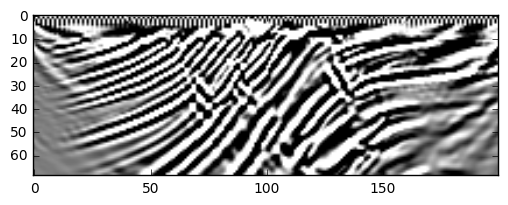

In [43]:
# RTM result
fig4 = plt.figure()
l = plt.imshow(np.diff(np.diff(np.transpose(grad[40:-40,40:-40]),1,0),1), vmin=-100, vmax=100, aspect=1, cmap=cm.gray)
plt.show()
# Looks ok will rerun with better model

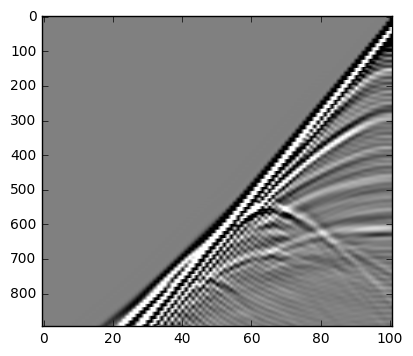

In [44]:
# Shot record
fig5 = plt.figure()
l = plt.imshow(rec, vmin=-1, vmax=1, aspect=.1, cmap=cm.gray)
plt.show()

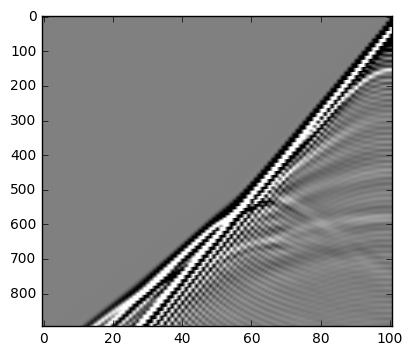

In [45]:
# Shot record
fig6 = plt.figure()
l = plt.imshow(rec0, vmin=-1, vmax=1, aspect=.1, cmap=cm.gray)
plt.show()

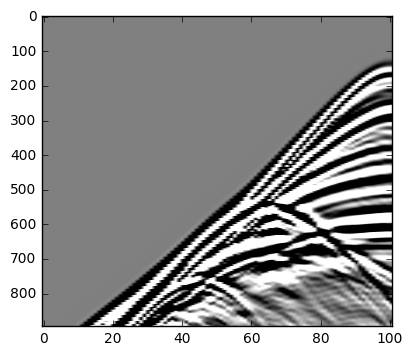

In [46]:
fig7 = plt.figure()
l = plt.imshow(rec0 - rec, vmin=-.1, vmax=.1, aspect=.1, cmap=cm.gray)
plt.show()